**Project Name:** Churn Prediction - Die Zeit

**Team:** Carlotta Ulm, Silas Mederer, Jonas Bechthold

**Date:** 2020-10-26 to 2020-11-27

**Description:** This notebook contains the customer segmentation part, which divides the subscribers in teh following two groups, based on the subscription type: 

**1. Die Zeit:** the print version of the newspaper. 
    
**2. Zeit digital:** the digital version of the newspaper. 
    
For both of these subscription types the feature selection (Chapter 2 and 3) is conducted in which the same methods as in the main machine learning notebook are used. 

After the feature selection a basic machine learning model (Chapter 4 and 5) is used and optimized (RandomForest), to see if there is a significant difference in the model results, when this subscription segmentation is used. 

For the third type of subscription (Zeit Christ & Welt) the dataset is remarkably smaller and therefore no machine learning was applied to this dataset. 

# Imports, Load Data

In [57]:
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

# data analysis and wrangling
import pandas as pd
import numpy as np
import math

# own modules
import eda_methods as eda

# visualization
import seaborn as sns
sns.set(style="white")  
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

#Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Imbalanced Learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# random state
random_state = 100

# Variables for plot sizes
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=14)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=14)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=14)    # legend fontsize
matplotlib.rc('figure', titlesize=20)

# Feature Selection - Customer Segmentation: DieZeit

### Splitting the dataframe in two separate frames - categorical and numerical

In [35]:
df = pd.read_csv('data/df_seg_diezeit_clean_engineered_all.csv')

In [36]:
# define number of important features
num_feats=20
y = df['churn']
X = df.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

In [37]:
cat_list = X.select_dtypes(exclude=['int', 'float']).columns
num_list = X.select_dtypes(include=['int', 'float']).columns

In [38]:
# categorical dataframe
X_cat = X[cat_list]

In [39]:
X_cat_dum = pd.get_dummies(X_cat,drop_first=True)

In [40]:
# numerical dataframe
X_num = X[num_list]

In [41]:
# scaling required
X_num = pd.DataFrame(MinMaxScaler().fit_transform(X_num), columns=X_num.columns, index=df.index)

## Feature importance by simple Random Forest

In [42]:
X_RF = pd.concat([X_cat_dum,X_num], axis=1)

In [43]:
RF = RandomForestClassifier(n_jobs=-1)

model = RF.fit(X_RF, y)

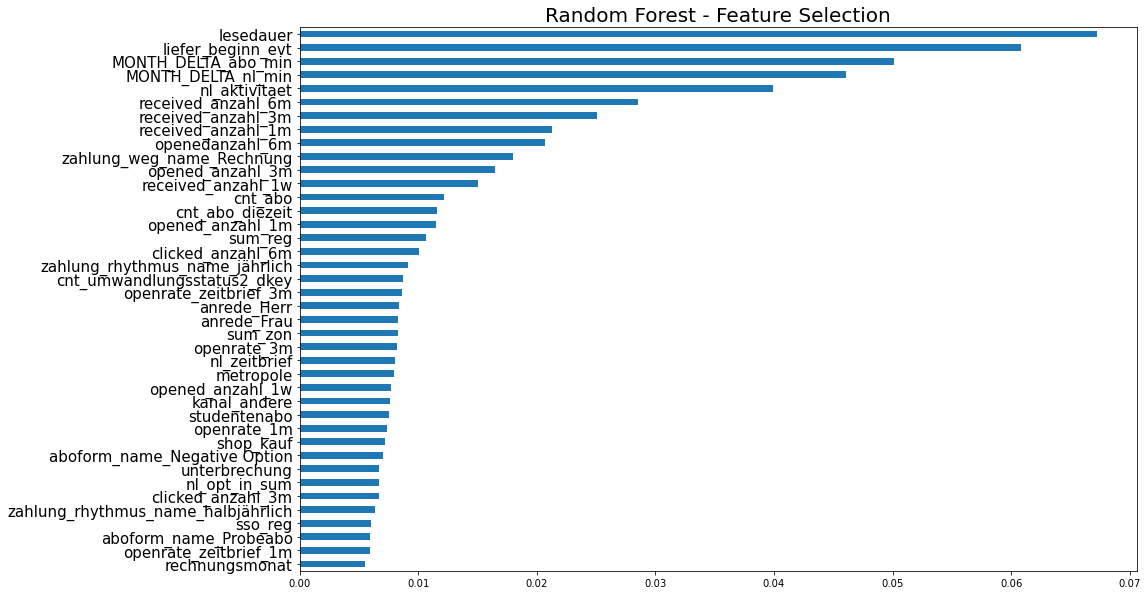

In [44]:
pd.Series(model.feature_importances_, index=X_RF.columns).nlargest(40).plot(kind='barh', figsize=(15,10)).invert_yaxis();

plt.yticks(size=15);
plt.title('Random Forest - Feature Selection', size=20);

## Feature Importance for Combined Features - Top 40

### Person´s Correlation

In [45]:
X_comb = pd.concat([X_cat_dum,X_num],axis=1)

In [46]:
X_comb.shape

(101203, 305)

In [47]:
X_comb_scaled = X_comb

In [48]:
X_comb_scaled.head(5)

kanal_B2B  kanal_E-Mailing  kanal_Eigenwerbung  kanal_Fremdwerbung  \
0          0                1                   0                   0   
1          0                0                   0                   1   
2          0                0                   0                   0   
3          0                0                   0                   0   
4          0                0                   0                   0   

   kanal_Mailings  kanal_SEA  kanal_Standwerbung  kanal_Telefonmarketing  \
0               0          0                   0                       0   
1               0          0                   0                       0   
2               0          0                   0                       1   
3               0          0                   0                       1   
4               0          0                   0                       0   

   kanal_andere  aboform_name_Geschenkabo  ...  nl_clicked_1w  nl_clicked_1m  \
0             0                         0  ...           0.25           0.50   
1             0                         0  ...           0.00           0.00   
2             0                         0  ...           0.25           0.25   
3             0                         0  ...           0.00           0.00   
4             1                         0  ...           0.25           0.25   

   nl_clicked_3m  nl_clicked_6m  nl_unsubscribed_1w  nl_unsubscribed_1m  \
0           0.00       0.000000            0.000000            0.000000   
1           0.00       0.000000            0.000000            0.000000   
2           0.25       0.333333            0.333333            0.333333   
3           0.00       0.000000            0.000000            0.000000   
4           0.00       0.000000            0.000000            0.000000   

   nl_unsubscribed_3m  nl_unsubscribed_6m  MONTH_DELTA_abo_min  \
0                0.00                 0.0             0.954036   
1                0.00                 0.0             0.954059   
2                0.25                 0.0             0.953760   
3                0.00                 0.0             0.953760   
4                0.00                 0.0             0.955205   

   MONTH_DELTA_nl_min  
0            0.888806  
1            0.000000  
2            0.987055  
3            0.944403  
4            0.937998  

[5 rows x 305 columns]

In [49]:
num_feats=40

In [50]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_comb_scaled, y,num_feats)
print(str(len(cor_feature)), 'selected features')

40 selected features


### Chi Squared

In [51]:
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_comb_scaled, y)
chi_support = chi_selector.get_support()
chi_feature = X_comb_scaled.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

40 selected features


### Recursive

In [52]:
rfe_selector = RFE(estimator=LogisticRegression(n_jobs=-1), n_features_to_select=num_feats, step=0.1, verbose=5)
rfe_selector.fit(X_comb_scaled, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X_comb_scaled.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 305 features.
Fitting estimator with 275 features.
Fitting estimator with 245 features.
Fitting estimator with 215 features.
Fitting estimator with 185 features.
Fitting estimator with 155 features.
Fitting estimator with 125 features.
Fitting estimator with 95 features.
Fitting estimator with 65 features.
40 selected features


### Model selected

#### LogisticRegression

In [53]:
embeded_lr_selector = SelectFromModel(LogisticRegression(n_jobs=-1), max_features=num_feats)
embeded_lr_selector.fit(X_comb_scaled, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_comb_scaled.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

40 selected features


#### RandomForest

In [54]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,n_jobs=-1), max_features=num_feats)
embeded_rf_selector.fit(X_comb_scaled, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_comb_scaled.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

40 selected features


### Conclusion

In [55]:
feature_name = X_comb.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [56]:
feature_selection_df[0:40]

Feature  Pearson  Chi-2    RFE  Logistics  \
1                        nl_aktivitaet     True   True   True       True   
2                    liefer_beginn_evt     True   True   True       True   
3                            lesedauer     True   True   True       True   
4    received_anzahl_bestandskunden_6m     True   True   True       True   
5    received_anzahl_bestandskunden_3m     True   True   True       True   
6                   received_anzahl_6m     True  False   True       True   
7                   received_anzahl_1w     True  False   True       True   
8                      openedanzahl_6m     True  False   True       True   
9                    clicked_anzahl_6m     True  False   True       True   
10                   clicked_anzahl_3m     True  False   True       True   
11                  MONTH_DELTA_nl_min     True  False   True       True   
12           zahlung_weg_name_Rechnung     True   True  False      False   
13      zahlung_rhythmus_name_jährlich     True   True  False      False   
14  zahlung_rhythmus_name_halbjährlich     True   True  False      False   
15                       unterbrechung     True   True  False      False   
16                        studentenabo     True   True  False      False   
17                      rechnungsmonat     True   True  False      False   
18                  received_anzahl_3m     True  False   True      False   
19                  received_anzahl_1m     True  False  False       True   
20               openrate_zeitbrief_3m    False  False   True       True   
21             openrate_produktnews_3m     True  False   True       True   
22                    opened_anzahl_3m     True  False   True      False   
23                    opened_anzahl_1w    False  False   True       True   
24                       nl_opt_in_sum    False  False   True       True   
25                           metropole     True   True  False      False   
26                        kanal_andere     True   True  False      False   
27                     email_am_kunden     True  False   True       True   
28         cnt_umwandlungsstatus2_dkey    False  False   True       True   
29               aboform_name_Probeabo     True   True  False      False   
30        aboform_name_Negative Option     True   True  False      False   
31                 MONTH_DELTA_abo_min    False  False   True       True   
32  zahlung_rhythmus_name_zweijährlich    False  False   True       True   
33              unsubscribed_anzahl_6m    False  False   True       True   
34              unsubscribed_anzahl_3m    False  False   True       True   
35              unsubscribed_anzahl_1w    False  False   True       True   
36              unsubscribed_anzahl_1m    False  False   True       True   
37                             sum_reg    False  False   True      False   
38                           shop_kauf     True  False  False      False   
39        received_anzahl_zeitbrief_6m     True   True  False      False   
40      received_anzahl_produktnews_1m     True   True  False      False   

    Random Forest  Total  
1            True      5  
2            True      5  
3            True      5  
4           False      4  
5           False      4  
6            True      4  
7            True      4  
8            True      4  
9            True      4  
10           True      4  
11           True      4  
12           True      3  
13           True      3  
14           True      3  
15           True      3  
16           True      3  
17           True      3  
18           True      3  
19           True      3  
20           True      3  
21          False      3  
22           True      3  
23           True      3  
24           True      3  
25           True      3  
26           True      3  
27          False      3  
28           True      3  
29           True      3  
30           True      3  
31           True      3  
32          False      2  
33          False      

### Reducing correlated features from the set

In [57]:
important_features_combined_scale = feature_selection_df[feature_selection_df['Total'] >= 3].Feature.to_list()

In [58]:
important_features_combined_scale

['nl_aktivitaet',
 'liefer_beginn_evt',
 'lesedauer',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_bestandskunden_3m',
 'received_anzahl_6m',
 'received_anzahl_1w',
 'openedanzahl_6m',
 'clicked_anzahl_6m',
 'clicked_anzahl_3m',
 'MONTH_DELTA_nl_min',
 'zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'zahlung_rhythmus_name_halbjährlich',
 'unterbrechung',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_3m',
 'received_anzahl_1m',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_3m',
 'opened_anzahl_3m',
 'opened_anzahl_1w',
 'nl_opt_in_sum',
 'metropole',
 'kanal_andere',
 'email_am_kunden',
 'cnt_umwandlungsstatus2_dkey',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

<AxesSubplot:>

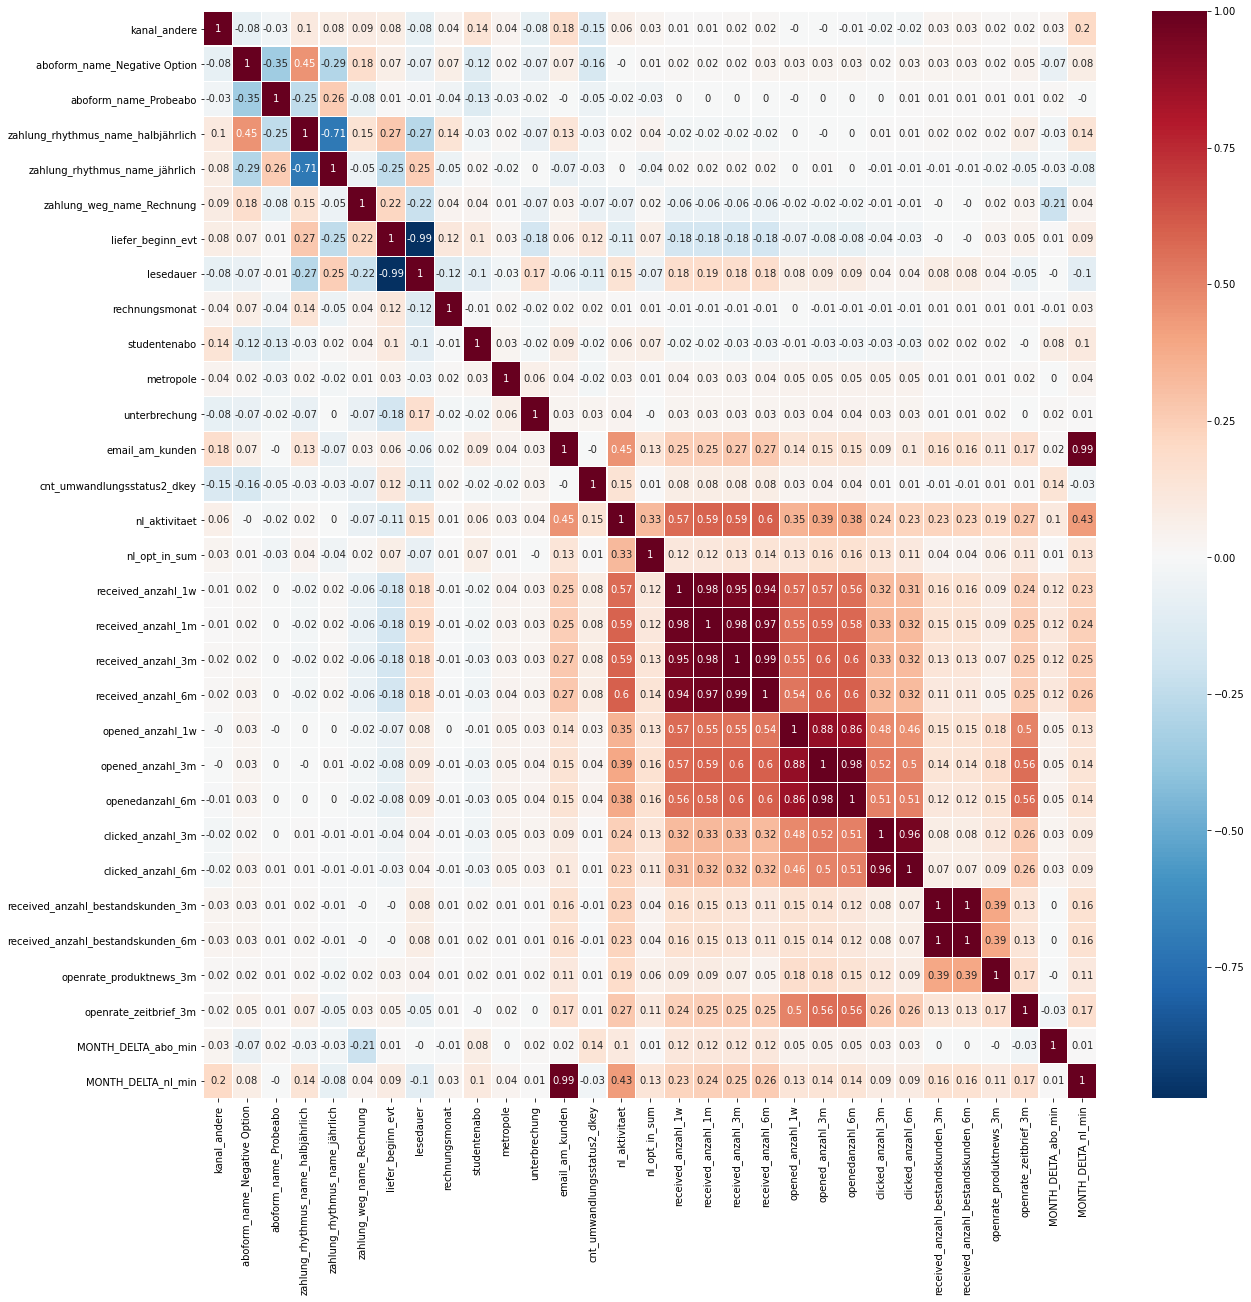

In [59]:
correlogram_combined_features = X_comb[X_comb.columns.intersection(important_features_combined_scale)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_combined_features.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

In [60]:
removelist1 = ['lesedauer','email_am_kunden','received_anzahl_1w','received_anzahl_1m','received_anzahl_3m','opened_anzahl_3m','opened_anzahl_1w','clicked_anzahl_3m','received_anzahl_bestandskunden_3m']

important_features2 = [i for i in important_features_combined_scale if i not in removelist1]
important_features2

['nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'clicked_anzahl_6m',
 'MONTH_DELTA_nl_min',
 'zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'zahlung_rhythmus_name_halbjährlich',
 'unterbrechung',
 'studentenabo',
 'rechnungsmonat',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_3m',
 'nl_opt_in_sum',
 'metropole',
 'kanal_andere',
 'cnt_umwandlungsstatus2_dkey',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

<AxesSubplot:>

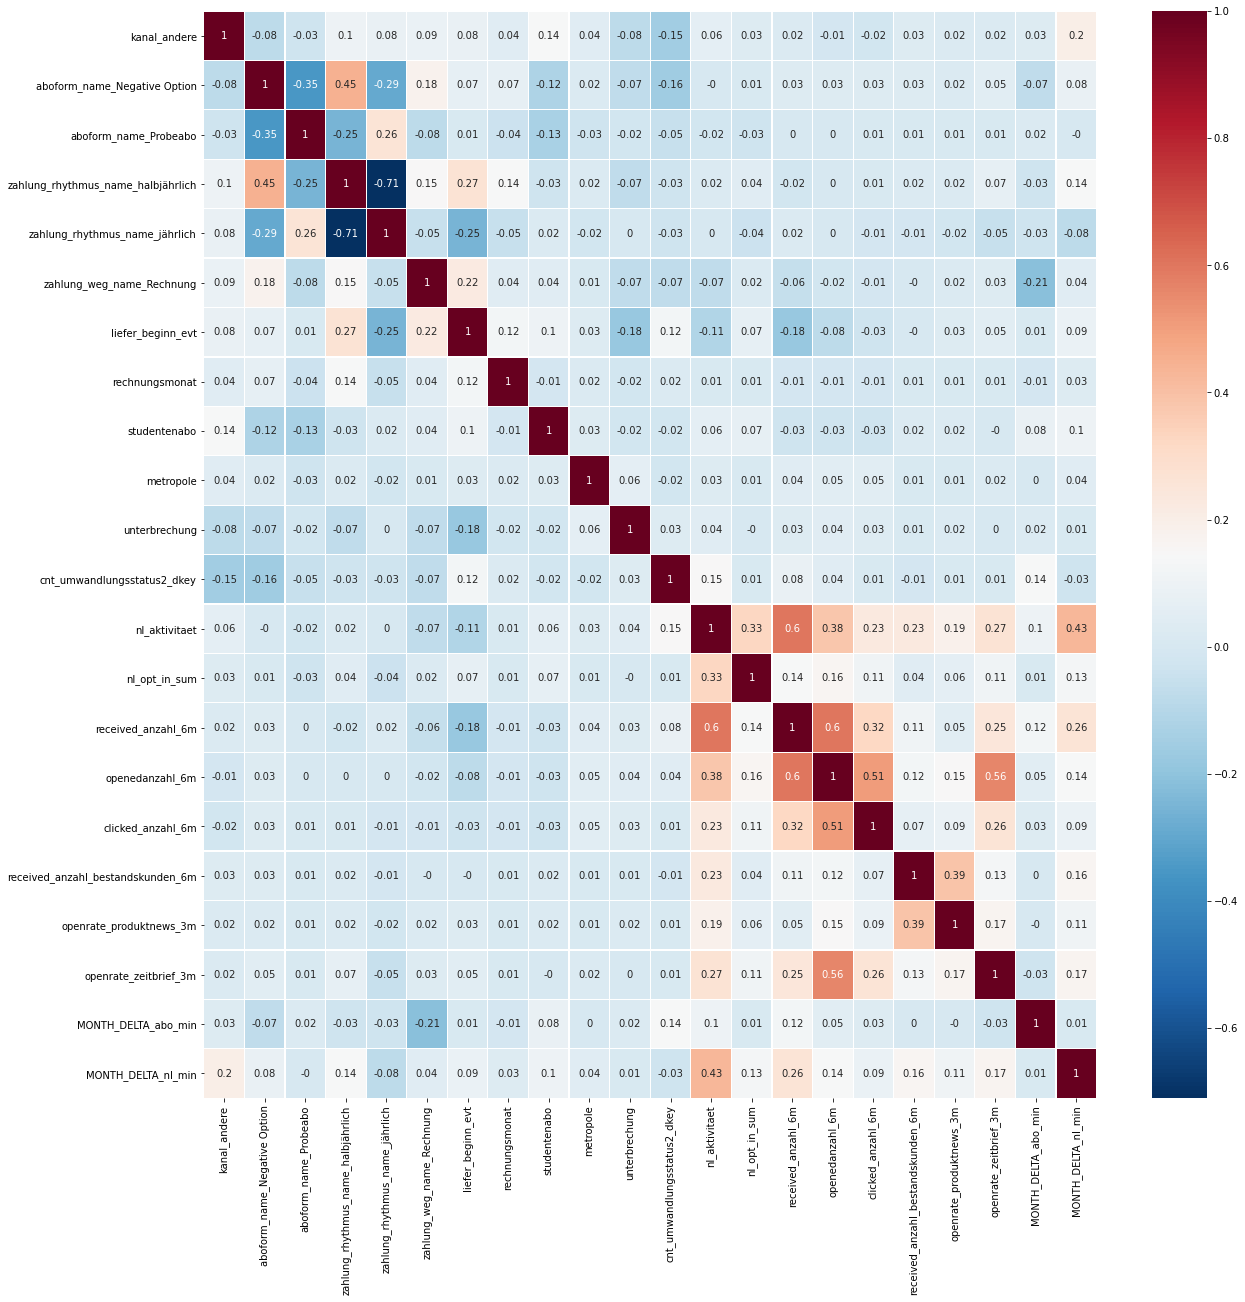

In [61]:
correlogram_combined_features = X_comb[X_comb.columns.intersection(important_features2)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_combined_features.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

### Final Feature Selection List

In [64]:
important_features2

['nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'clicked_anzahl_6m',
 'MONTH_DELTA_nl_min',
 'zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'zahlung_rhythmus_name_halbjährlich',
 'unterbrechung',
 'studentenabo',
 'rechnungsmonat',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_3m',
 'nl_opt_in_sum',
 'metropole',
 'kanal_andere',
 'cnt_umwandlungsstatus2_dkey',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

['nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'clicked_anzahl_6m',
 'MONTH_DELTA_nl_min',
 'zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'zahlung_rhythmus_name_halbjährlich',
 'unterbrechung',
 'studentenabo',
 'rechnungsmonat',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_3m',
 'nl_opt_in_sum',
 'metropole',
 'kanal_andere',
 'cnt_umwandlungsstatus2_dkey',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

-> **22 Top Features**

## Feature Importance for Combined Features - Top 100

### Person´s Correlation

In [65]:
num_feats=100

In [66]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_comb_scaled, y,num_feats)
print(str(len(cor_feature)), 'selected features')

100 selected features


### Chi Squared

In [67]:
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_comb_scaled, y)
chi_support = chi_selector.get_support()
chi_feature = X_comb_scaled.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


### Recursive

In [68]:
rfe_selector = RFE(estimator=LogisticRegression(n_jobs=-1), n_features_to_select=num_feats, step=0.1, verbose=5)
rfe_selector.fit(X_comb_scaled, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X_comb_scaled.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 305 features.
Fitting estimator with 275 features.
Fitting estimator with 245 features.
Fitting estimator with 215 features.
Fitting estimator with 185 features.
Fitting estimator with 155 features.
Fitting estimator with 125 features.
100 selected features


### Model selected

#### LogisticRegression

In [69]:
embeded_lr_selector = SelectFromModel(LogisticRegression(n_jobs=-1), max_features=num_feats)
embeded_lr_selector.fit(X_comb_scaled, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_comb_scaled.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

76 selected features


#### RandomForest

In [70]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,n_jobs=-1), max_features=num_feats)
embeded_rf_selector.fit(X_comb_scaled, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_comb_scaled.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

70 selected features


### Conclusion

In [71]:
feature_name = X_comb.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [73]:
feature_selection_df.head(60)

Feature  Pearson  Chi-2    RFE  Logistics  \
1               zahlung_weg_name_Rechnung     True   True   True       True   
2          zahlung_rhythmus_name_jährlich     True   True   True       True   
3                      received_anzahl_6m     True   True   True       True   
4                      received_anzahl_3m     True   True   True       True   
5                      received_anzahl_1w     True   True   True       True   
6                      received_anzahl_1m     True   True   True       True   
7                         openedanzahl_6m     True   True   True       True   
8                           nl_aktivitaet     True   True   True       True   
9                       liefer_beginn_evt     True   True   True       True   
10                              lesedauer     True   True   True       True   
11                        cnt_abo_magazin     True   True   True       True   
12                        cnt_abo_diezeit     True   True   True       True   
13                           clickrate_3m     True   True   True       True   
14                      clicked_anzahl_6m     True   True   True       True   
15                      clicked_anzahl_3m     True   True   True       True   
16                                che_reg     True   True   True       True   
17               aboform_name_Geschenkabo     True   True   True       True   
18                     MONTH_DELTA_nl_min     True   True   True       True   
19                 unsubscribed_anzahl_1w     True   True   True       True   
20                 unsubscribed_anzahl_1m     True   True   True       True   
21                  titel_sonstiger Titel     True   True   True       True   
22                         rechnungsmonat     True   True   True      False   
23      received_anzahl_bestandskunden_6m     True   True   True       True   
24      received_anzahl_bestandskunden_3m     True   True   True       True   
25                openrate_produktnews_3m     True   True   True       True   
26             openrate_bestandskunden_3m     True   True   True       True   
27           opened_anzahl_produktnews_3m     True   True   True       True   
28                       opened_anzahl_3m     True   True   True      False   
29                       opened_anzahl_1w     True  False   True       True   
30                       opened_anzahl_1m     True  False   True       True   
31                            nl_zeitshop     True   True   True      False   
32                          nl_opt_in_sum     True  False   True       True   
33                         nl_bounced_sum     True   True   True      False   
34                        email_am_kunden     True   True   True       True   
35                           clickrate_1w     True   True   True       True   
36              clicked_anzahl_hamburg_3m     True   True   True       True   
37                aboform_name_Prämienabo     True   True   True       True   
38  zahlung_rhythmus_name_vierteljährlich     True   True  False      False   
39     zahlung_rhythmus_name_halbjährlich     True   True  False      False   
40                          unterbrechung     True   True  False      False   
41                 unsubscribed_anzahl_6m     True  False   True       True   
42                 unsubscribed_anzahl_3m     True  False   True       True   
43                           studentenabo     True   True  False      False   
44         received_anzahl_produktnews_1m     True   True   True      False   
45                               plz_2_68    False   True   True       True   
46                               plz_2_12     True   True   True      False   
47                               plz_2_10     True   True   True      False   
48                                plz_1_1     True   True  False      False   
49                  openrate_zeitbrief_3m    False  False   True       True   
50                openrate_produktnews_1m     True  False   True       True   
51   

### Reducing correlated features from the set

In [74]:
important_features_combined_scale = feature_selection_df[feature_selection_df['Total'] >= 3].Feature.to_list()

In [75]:
len(important_features_combined_scale)

72

In [76]:
important_features_combined_scale[0:20]

['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'received_anzahl_6m',
 'received_anzahl_3m',
 'received_anzahl_1w',
 'received_anzahl_1m',
 'openedanzahl_6m',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'lesedauer',
 'cnt_abo_magazin',
 'cnt_abo_diezeit',
 'clickrate_3m',
 'clicked_anzahl_6m',
 'clicked_anzahl_3m',
 'che_reg',
 'aboform_name_Geschenkabo',
 'MONTH_DELTA_nl_min',
 'unsubscribed_anzahl_1w',
 'unsubscribed_anzahl_1m']

<AxesSubplot:>

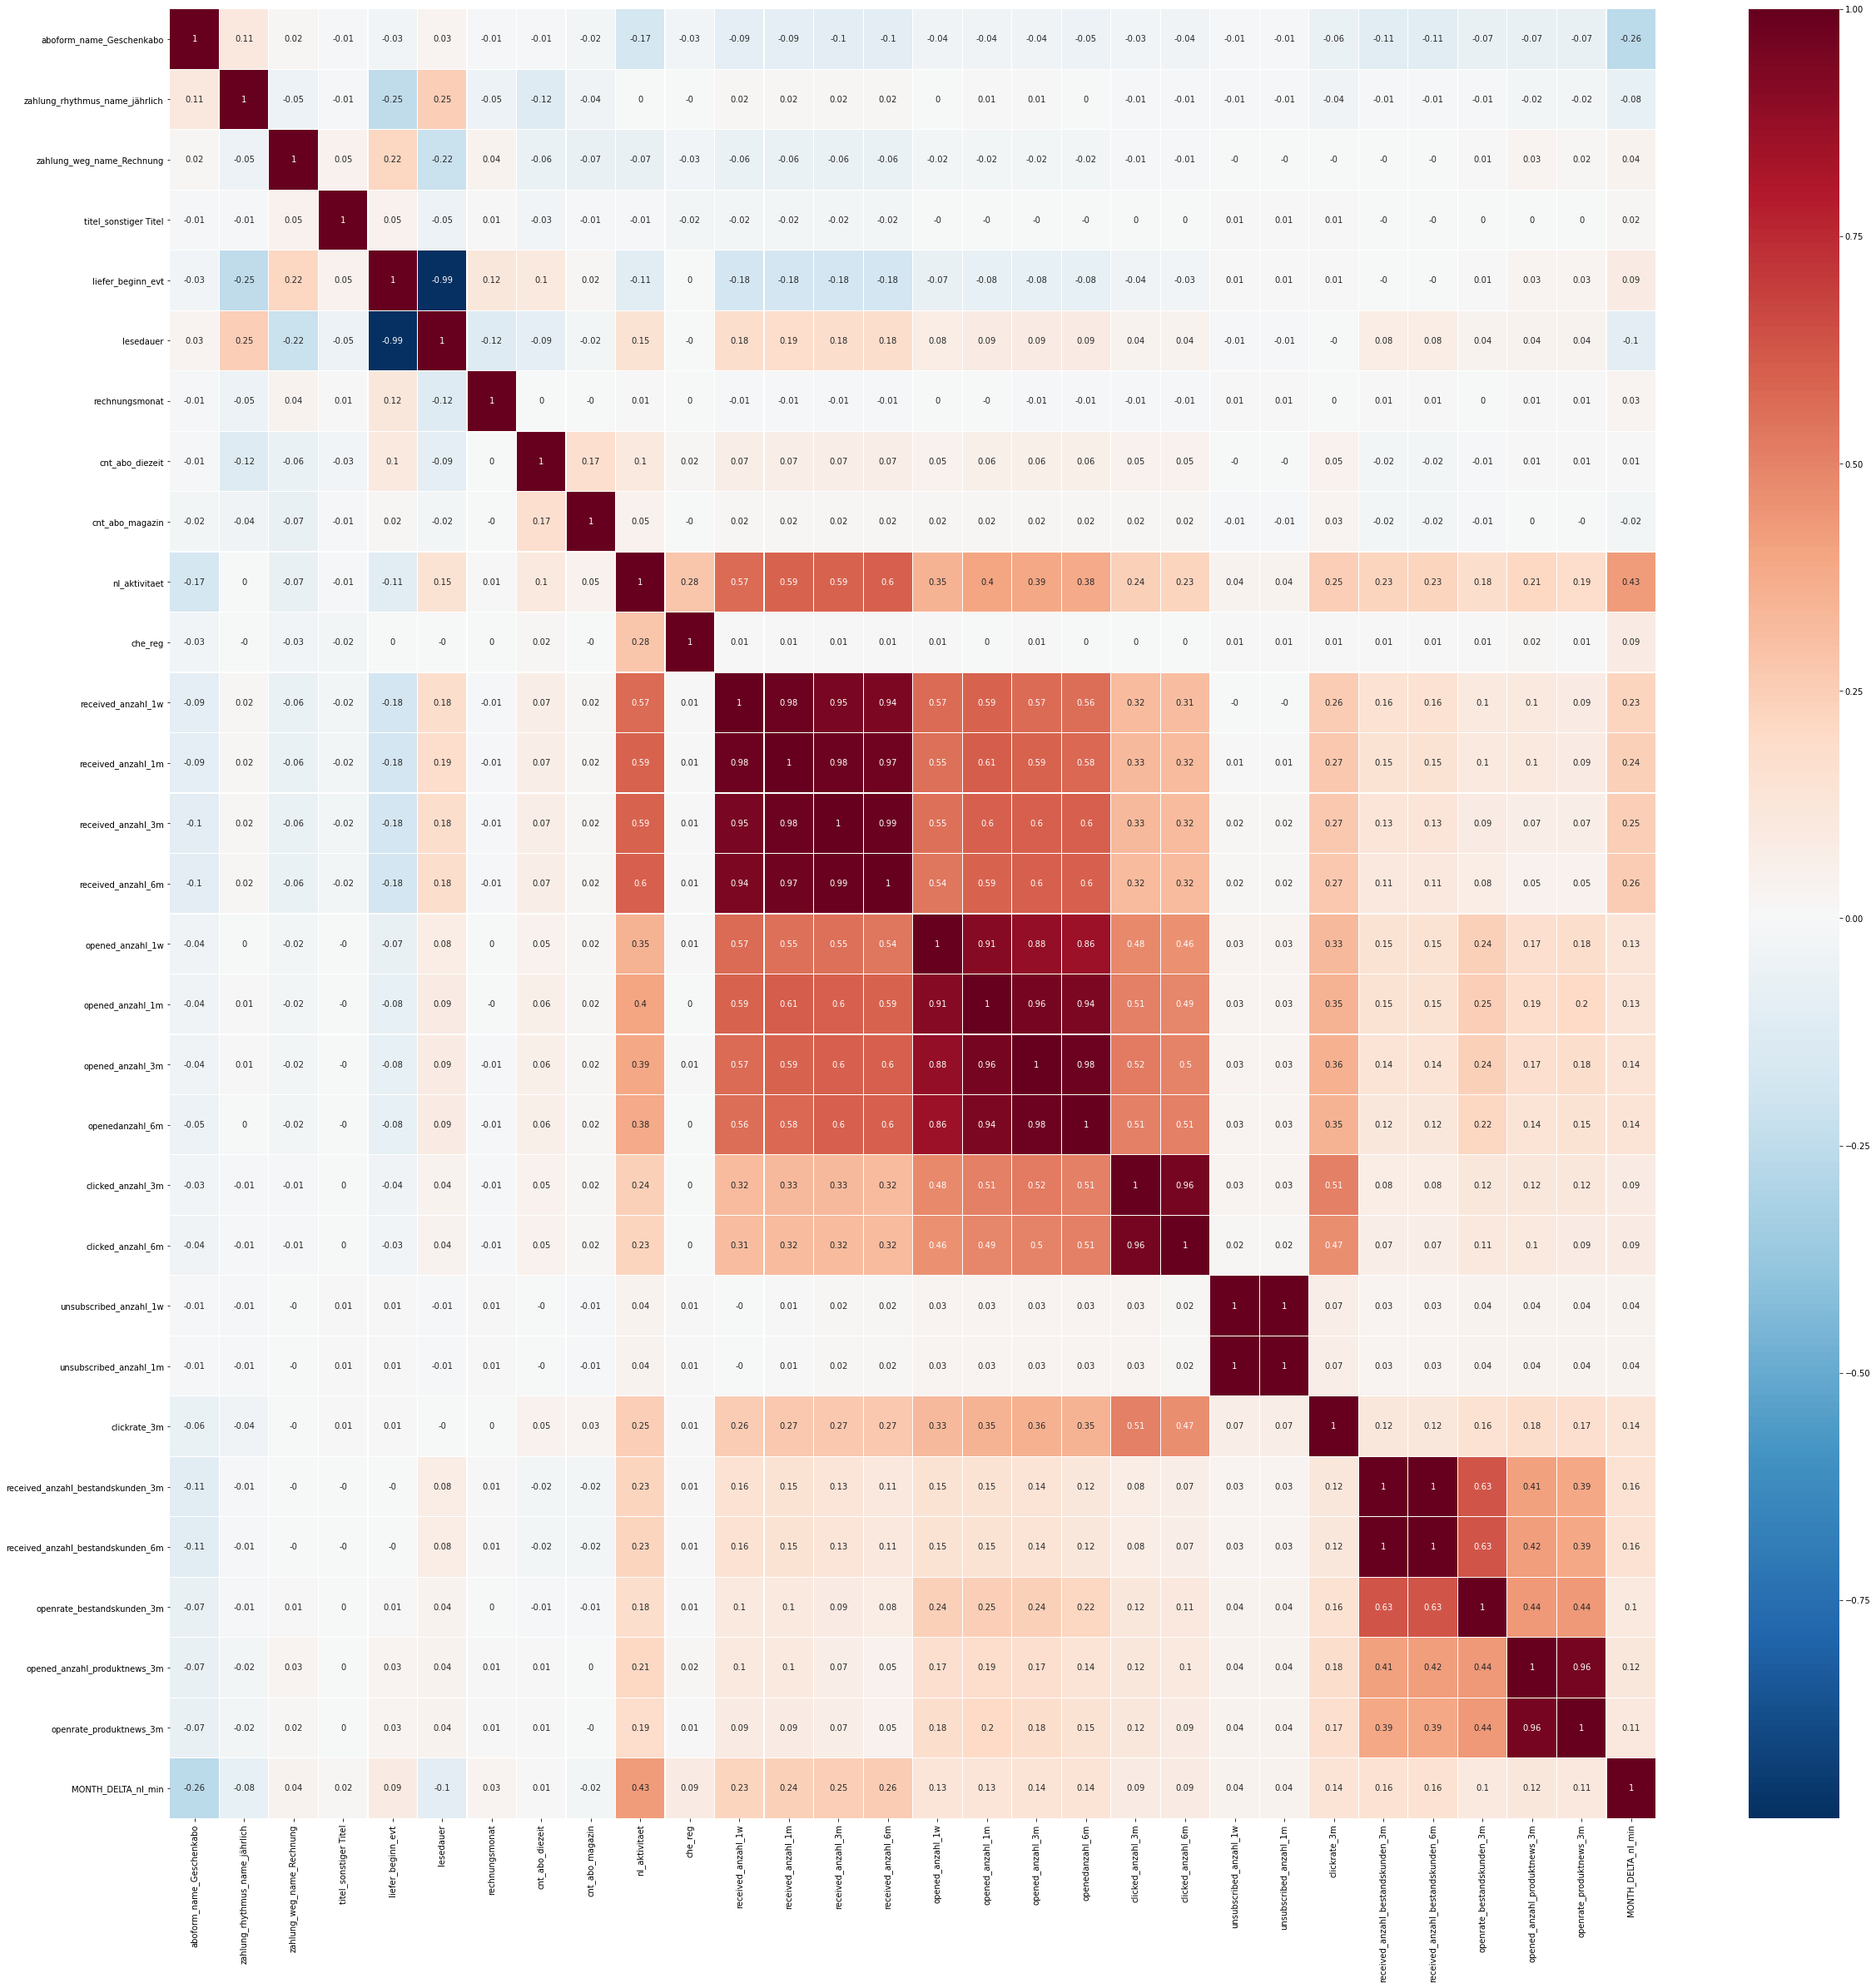

In [77]:
correlogram_combined_features_1 = X_comb[X_comb.columns.intersection(important_features_combined_scale[0:30])]
plt.figure(figsize=(40,40))
sns.heatmap(data=correlogram_combined_features_1.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

In [97]:
removelist1 = ['anrede_Herr','zahlung_rhythmus_name_halbjährlich','lesedauer','received_anzahl_1w','received_anzahl_1m','received_anzahl_3m','opened_anzahl_3m','opened_anzahl_1m','opened_anzahl_1w','clicked_anzahl_3m','unsubscribed_anzahl_1w','unsubscribed_anzahl_3m','received_anzahl_bestandskunden_3m','opened_anzahl_produktnews_3m','email_am_kunden','opened_anzahl_bestandskunden_1m','openrate_bestandskunden_3m','clicked_anzahl_produktnews_3m','land_iso_code_DE']

important_features2 = [i for i in important_features_combined_scale if i not in removelist1]
len(important_features2)

53

<AxesSubplot:>

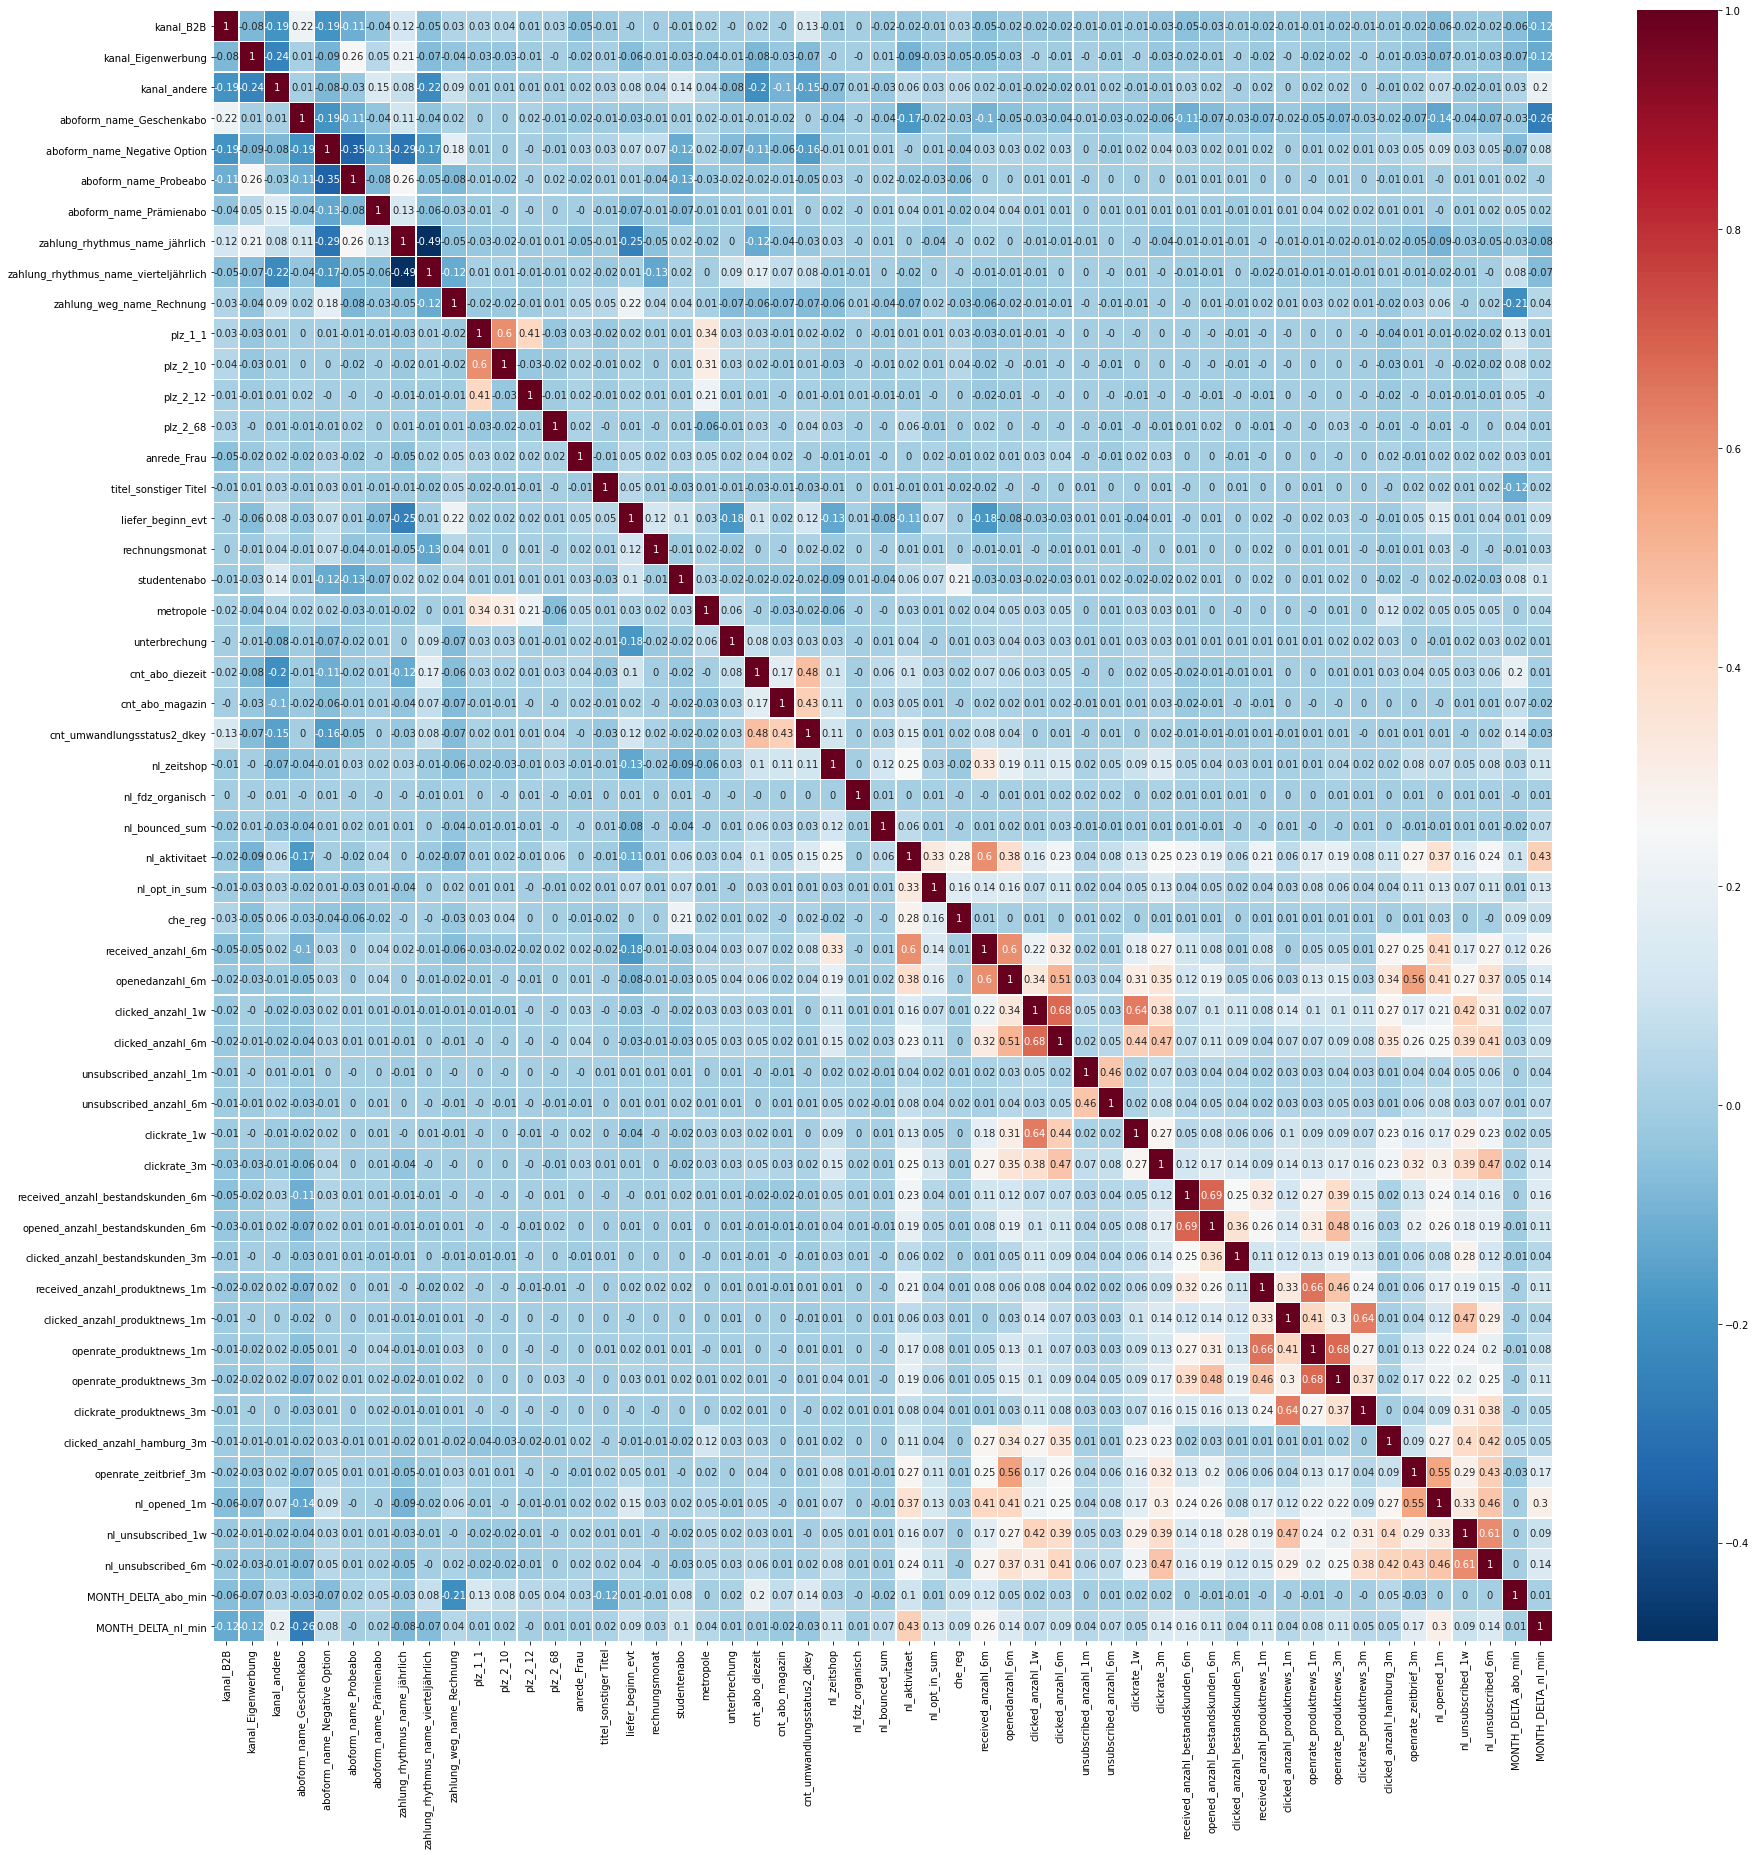

In [98]:
correlogram_combined_features_2 = X_comb[X_comb.columns.intersection(important_features2)]
plt.figure(figsize=(30,30))
sns.heatmap(data=correlogram_combined_features_2.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

### Final Feature Selection List:

In [99]:
important_features2

['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_abo_magazin',
 'cnt_abo_diezeit',
 'clickrate_3m',
 'clicked_anzahl_6m',
 'che_reg',
 'aboform_name_Geschenkabo',
 'MONTH_DELTA_nl_min',
 'unsubscribed_anzahl_1m',
 'titel_sonstiger Titel',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'openrate_produktnews_3m',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'nl_bounced_sum',
 'clickrate_1w',
 'clicked_anzahl_hamburg_3m',
 'aboform_name_Prämienabo',
 'zahlung_rhythmus_name_vierteljährlich',
 'unterbrechung',
 'unsubscribed_anzahl_6m',
 'studentenabo',
 'received_anzahl_produktnews_1m',
 'plz_2_68',
 'plz_2_12',
 'plz_2_10',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_1m',
 'opened_anzahl_bestandskunden_6m',
 'nl_unsubscribed_6m',
 'nl_unsubscribed_1w',
 'nl_opened_1m',
 'nl_fdz_organisch',
 'metropole',
 'kanal_andere',
 'kanal_Eigenwerbung',
 'kanal_B2B',
 'cnt_umwan

['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_abo_magazin',
 'cnt_abo_diezeit',
 'clickrate_3m',
 'clicked_anzahl_6m',
 'che_reg',
 'aboform_name_Geschenkabo',
 'MONTH_DELTA_nl_min',
 'unsubscribed_anzahl_1m',
 'titel_sonstiger Titel',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'openrate_produktnews_3m',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'nl_bounced_sum',
 'clickrate_1w',
 'clicked_anzahl_hamburg_3m',
 'aboform_name_Prämienabo',
 'zahlung_rhythmus_name_vierteljährlich',
 'unterbrechung',
 'unsubscribed_anzahl_6m',
 'studentenabo',
 'received_anzahl_produktnews_1m',
 'plz_2_68',
 'plz_2_12',
 'plz_2_10',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_1m',
 'opened_anzahl_bestandskunden_6m',
 'nl_unsubscribed_6m',
 'nl_unsubscribed_1w',
 'nl_opened_1m',
 'nl_fdz_organisch',
 'metropole',
 'kanal_andere',
 'kanal_Eigenwerbung',
 'kanal_B2B',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_produktnews_3m',
 'clicked_anzahl_produktnews_1m',
 'clicked_anzahl_bestandskunden_3m',
 'clicked_anzahl_1w',
 'anrede_Frau',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

In [100]:
len(important_features2)

53

-> **53 top features**

# Feature Selection - Customer Segmentation: Zeit digital

### Splitting the dataframe in two separate frames - categorical and numerical

In [3]:
df = pd.read_csv('data/df_seg_zeitdigital_clean_engineered_all.csv')

In [4]:
# define number of important features
y = df['churn']
X = df.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

In [5]:
cat_list = X.select_dtypes(exclude=['int', 'float']).columns
num_list = X.select_dtypes(include=['int', 'float']).columns

In [6]:
# categorical dataframe
X_cat = X[cat_list]

In [7]:
X_cat_dum = pd.get_dummies(X_cat,drop_first=True)

In [8]:
# numerical dataframe
X_num = X[num_list]

In [9]:
# scaling required
X_num = pd.DataFrame(MinMaxScaler().fit_transform(X_num), columns=X_num.columns, index=df.index)

## Feature importance by simple Random Forest

In [10]:
X_RF = pd.concat([X_cat_dum,X_num], axis=1)

In [11]:
RF = RandomForestClassifier(n_jobs=-1)

model = RF.fit(X_RF, y)

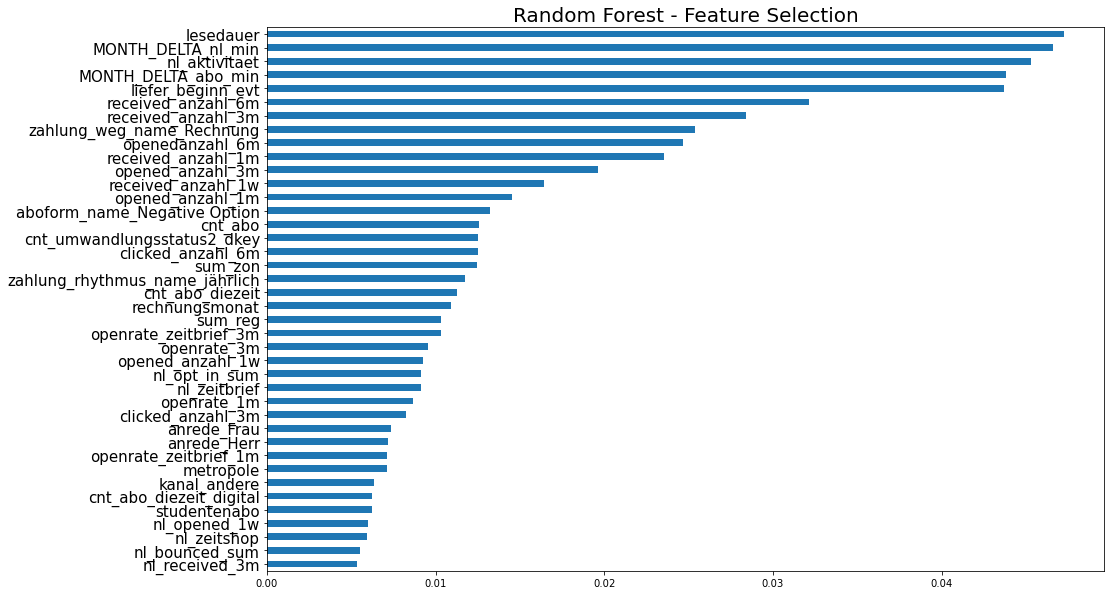

In [12]:
pd.Series(model.feature_importances_, index=X_RF.columns).nlargest(40).plot(kind='barh', figsize=(15,10)).invert_yaxis();

plt.yticks(size=15);
plt.title('Random Forest - Feature Selection', size=20);

## Feature Importance for Combined Features - Top 40

### Person´s Correlation

In [13]:
X_comb = pd.concat([X_cat_dum,X_num],axis=1)

In [14]:
X_comb.shape

(77081, 302)

In [15]:
X_comb_scaled = X_comb

In [16]:
X_comb_scaled.head(5)

kanal_E-Mailing  kanal_Eigenwerbung  kanal_Fremdwerbung  kanal_Mailings  \
0                0                   0                   0               0   
1                0                   0                   0               0   
2                0                   0                   0               0   
3                0                   0                   0               0   
4                0                   0                   0               0   

   kanal_SEA  kanal_Standwerbung  kanal_Telefonmarketing  kanal_andere  \
0          0                   0                       0             1   
1          0                   0                       0             1   
2          0                   0                       0             1   
3          0                   0                       0             1   
4          0                   0                       0             1   

   aboform_name_Geschenkabo  aboform_name_Negative Option  ...  nl_clicked_1w  \
0                         0                             0  ...           0.25   
1                         0                             0  ...           0.25   
2                         0                             0  ...           0.25   
3                         0                             0  ...           0.25   
4                         0                             0  ...           0.00   

   nl_clicked_1m  nl_clicked_3m  nl_clicked_6m  nl_unsubscribed_1w  \
0           0.25       0.333333            0.0                 0.0   
1           0.25       0.333333            0.0                 0.0   
2           0.25       0.333333            0.0                 0.0   
3           0.25       0.333333            0.0                 0.0   
4           0.00       0.333333            0.0                 0.0   

   nl_unsubscribed_1m  nl_unsubscribed_3m  nl_unsubscribed_6m  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   MONTH_DELTA_abo_min  MONTH_DELTA_nl_min  
0             0.880126            0.877397  
1             0.880126            0.877397  
2             0.880126            0.877397  
3             0.953055            0.944025  
4             0.000000            0.942549  

[5 rows x 302 columns]

In [17]:
num_feats=40

In [18]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_comb_scaled, y,num_feats)
print(str(len(cor_feature)), 'selected features')

/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


40 selected features


### Chi Squared

In [19]:
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_comb_scaled, y)
chi_support = chi_selector.get_support()
chi_feature = X_comb_scaled.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

40 selected features


### Recursive

In [21]:
rfe_selector = RFE(estimator=LogisticRegression(n_jobs=-1), n_features_to_select=num_feats, step=0.1, verbose=5)
rfe_selector.fit(X_comb_scaled, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X_comb_scaled.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 302 features.
Fitting estimator with 272 features.
Fitting estimator with 242 features.
Fitting estimator with 212 features.
Fitting estimator with 182 features.
Fitting estimator with 152 features.
Fitting estimator with 122 features.
Fitting estimator with 92 features.
Fitting estimator with 62 features.
40 selected features


### Model selected

#### LogisticRegression

In [22]:
embeded_lr_selector = SelectFromModel(LogisticRegression(n_jobs=-1), max_features=num_feats)
embeded_lr_selector.fit(X_comb_scaled, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_comb_scaled.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

40 selected features


#### RandomForest

In [23]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,n_jobs=-1), max_features=num_feats)
embeded_rf_selector.fit(X_comb_scaled, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_comb_scaled.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

40 selected features


### Conclusion

In [24]:
feature_name = X_comb.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [25]:
feature_selection_df[0:40]

Feature  Pearson  Chi-2    RFE  Logistics  \
1            zahlung_weg_name_Rechnung     True   True   True       True   
2                       rechnungsmonat     True   True   True       True   
3                         nl_zeitbrief     True   True   True       True   
4                        nl_aktivitaet     True   True   True       True   
5                    liefer_beginn_evt     True   True   True       True   
6                            lesedauer     True   True   True       True   
7                   received_anzahl_6m     True  False   True       True   
8                   received_anzahl_1w     True  False   True       True   
9                      openedanzahl_6m     True  False   True       True   
10                    opened_anzahl_3m     True  False   True       True   
11                    opened_anzahl_1w     True  False   True       True   
12                   clicked_anzahl_6m     True  False   True       True   
13                   clicked_anzahl_3m     True  False   True       True   
14                  MONTH_DELTA_nl_min     True  False   True       True   
15      zahlung_rhythmus_name_jährlich     True   True  False      False   
16                             sum_zon     True   True  False      False   
17                        studentenabo     True   True  False      False   
18                  received_anzahl_1m     True  False   True      False   
19                         nl_zeitshop     True   True  False      False   
20                    land_iso_code_DE     True  False   True       True   
21                        kanal_andere     True   True  False      False   
22         cnt_umwandlungsstatus2_dkey     True   True  False      False   
23             cnt_abo_diezeit_digital    False  False   True       True   
24                     cnt_abo_diezeit     True   True  False      False   
25                             cnt_abo     True   True  False      False   
26                         anrede_Herr    False  False   True       True   
27                         anrede_Frau    False  False   True       True   
28        aboform_name_Negative Option     True   True  False      False   
29                 MONTH_DELTA_abo_min    False  False   True       True   
30                          zon_zp_red     True   True  False      False   
31                      zon_che_opt_in    False  False   True       True   
32  zahlung_rhythmus_name_zweijährlich    False  False   True       True   
33              unsubscribed_anzahl_6m    False  False   True       True   
34              unsubscribed_anzahl_3m    False  False   True       True   
35              unsubscribed_anzahl_1w    False  False   True       True   
36              unsubscribed_anzahl_1m    False  False   True       True   
37                             sum_reg    False  False   True      False   
38        received_anzahl_zeitbrief_6m     True   True  False      False   
39        received_anzahl_zeitbrief_3m     True   True  False      False   
40   received_anzahl_bestandskunden_1m     True   True  False      False   

    Random Forest  Total  
1            True      5  
2            True      5  
3            True      5  
4            True      5  
5            True      5  
6            True      5  
7            True      4  
8            True      4  
9            True      4  
10           True      4  
11           True      4  
12           True      4  
13           True      4  
14           True      4  
15           True      3  
16           True      3  
17           True      3  
18           True      3  
19           True      3  
20          False      3  
21           True      3  
22           True      3  
23           True      3  
24           True      3  
25           True      3  
26           True      3  
27           True      3  
28           True      3  
29           True      3  
30          False      2  
31          False      2  
32          False      2  
33          False      

### Reducing correlated features from the set

In [26]:
important_features_combined_scale = feature_selection_df[feature_selection_df['Total'] >= 3].Feature.to_list()

In [27]:
important_features_combined_scale

['zahlung_weg_name_Rechnung',
 'rechnungsmonat',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'lesedauer',
 'received_anzahl_6m',
 'received_anzahl_1w',
 'openedanzahl_6m',
 'opened_anzahl_3m',
 'opened_anzahl_1w',
 'clicked_anzahl_6m',
 'clicked_anzahl_3m',
 'MONTH_DELTA_nl_min',
 'zahlung_rhythmus_name_jährlich',
 'sum_zon',
 'studentenabo',
 'received_anzahl_1m',
 'nl_zeitshop',
 'land_iso_code_DE',
 'kanal_andere',
 'cnt_umwandlungsstatus2_dkey',
 'cnt_abo_diezeit_digital',
 'cnt_abo_diezeit',
 'cnt_abo',
 'anrede_Herr',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

In [29]:
len(important_features_combined_scale)

29

<AxesSubplot:>

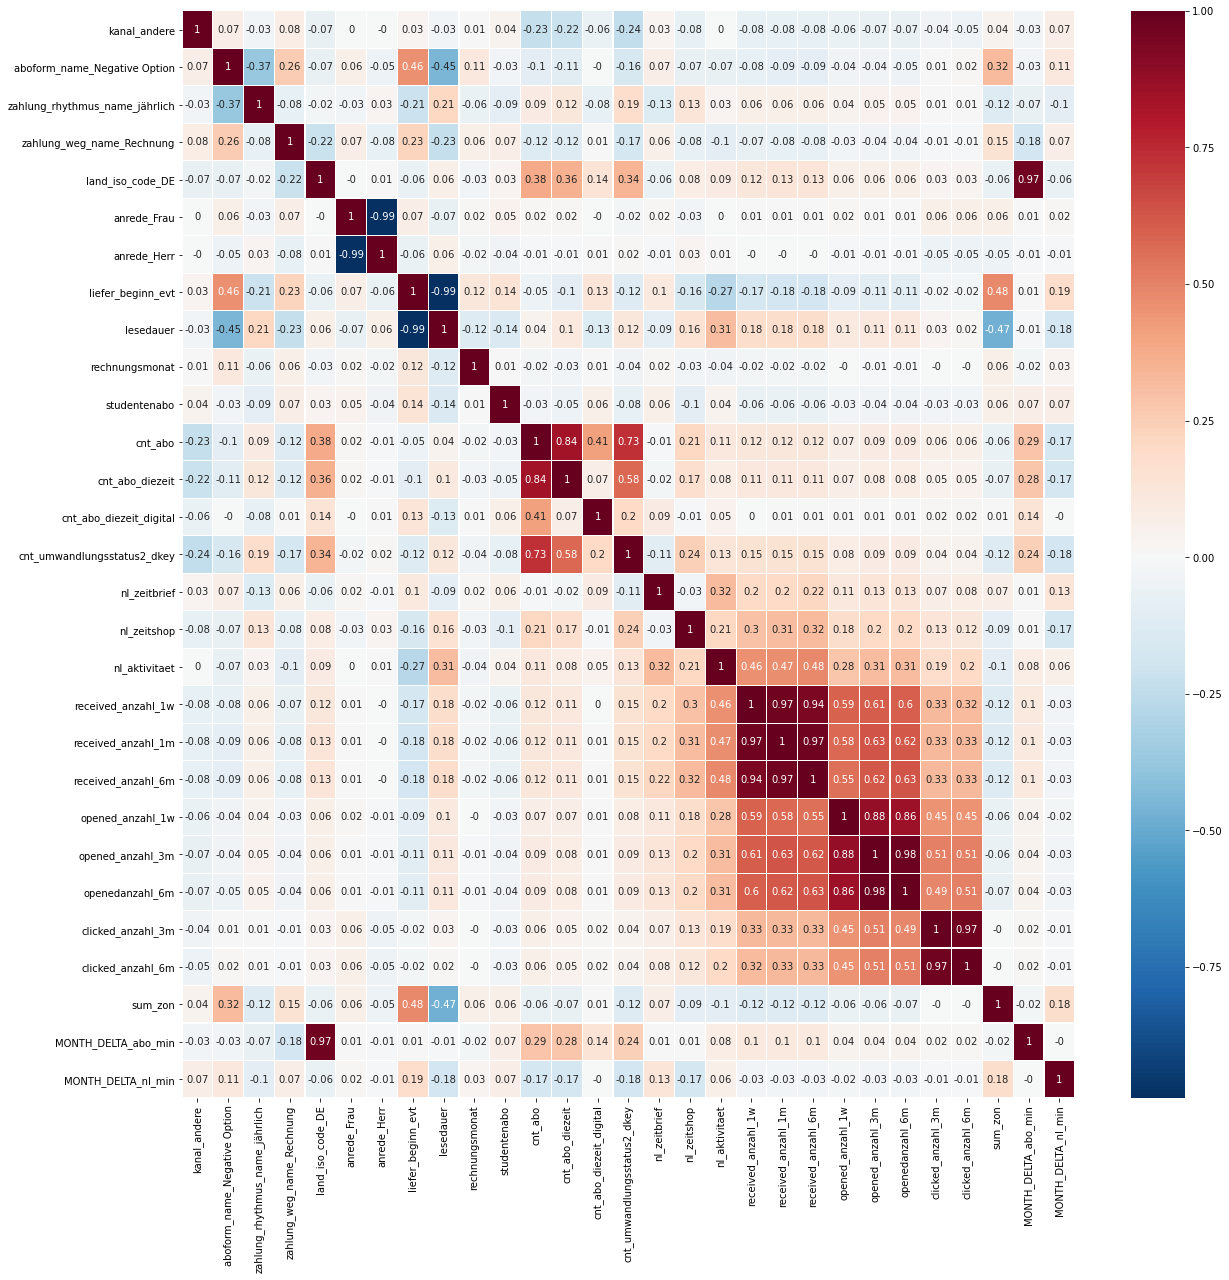

In [28]:
correlogram_combined_features = X_comb[X_comb.columns.intersection(important_features_combined_scale)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_combined_features.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

In [31]:
removelist1 = ['anrede_Herr', 'lesedauer','cnt_abo','land_iso_code_DE','received_anzahl_1w','received_anzahl_1m','opened_anzahl_1w','opened_anzahl_3m','clicked_anzahl_3m']

important_features2 = [i for i in important_features_combined_scale if i not in removelist1]
len(important_features2)

20

<AxesSubplot:>

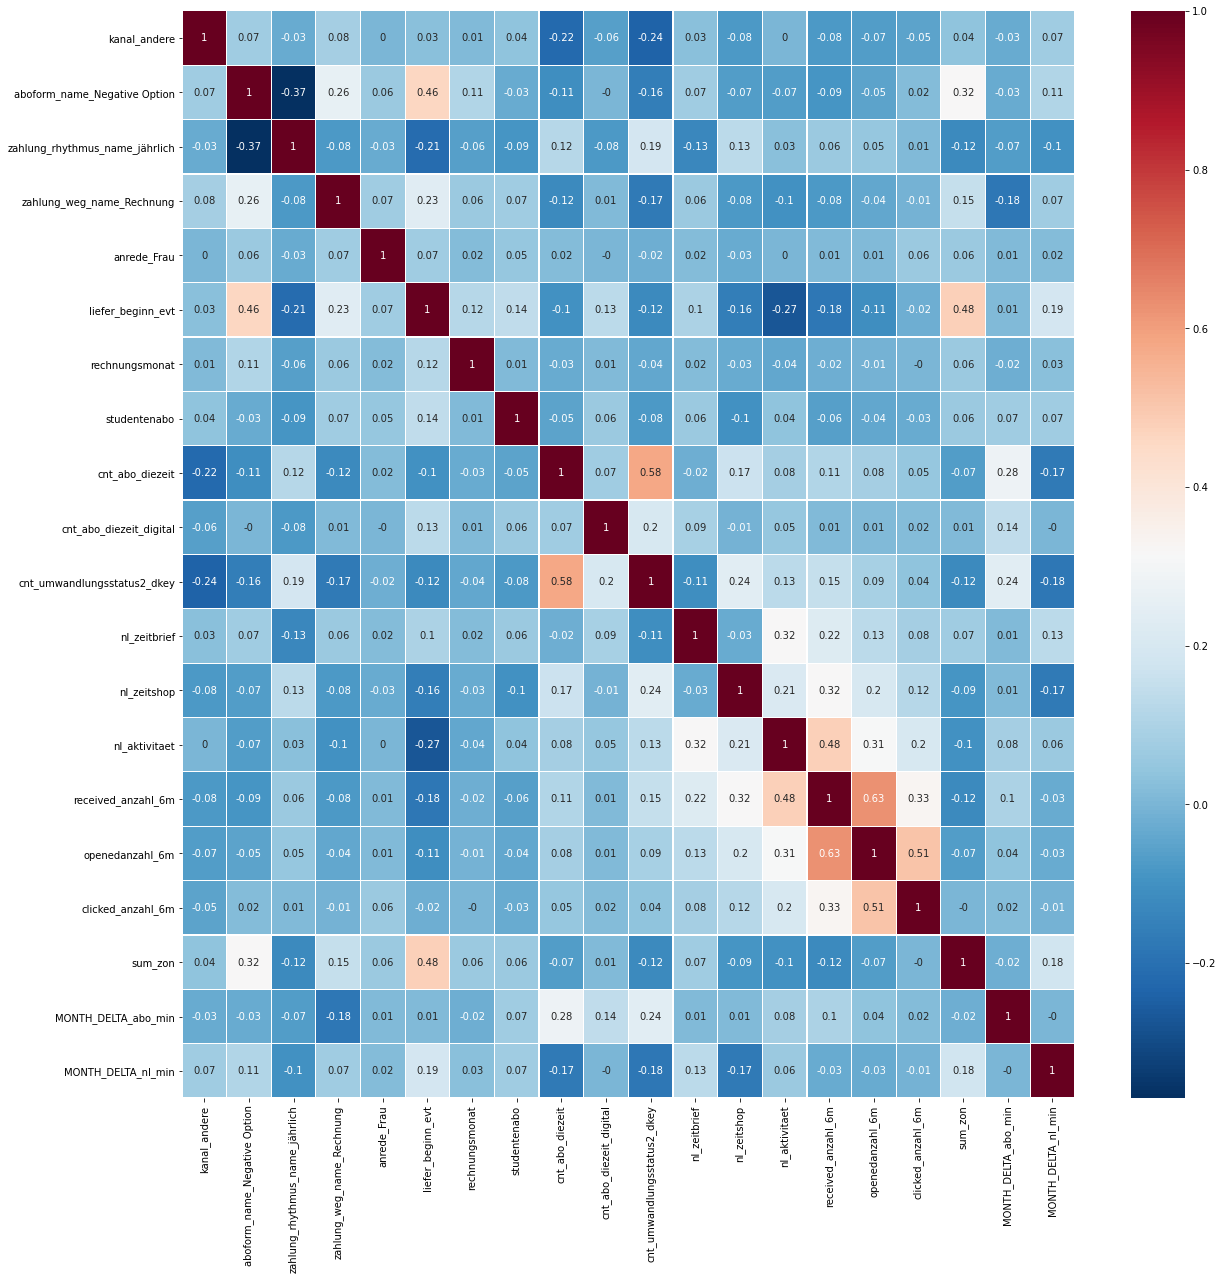

In [32]:
correlogram_combined_features = X_comb[X_comb.columns.intersection(important_features2)]
plt.figure(figsize=(20,20))
sns.heatmap(data=correlogram_combined_features.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

### Final Feature Selection List

In [64]:
important_features2

['nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'clicked_anzahl_6m',
 'MONTH_DELTA_nl_min',
 'zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'zahlung_rhythmus_name_halbjährlich',
 'unterbrechung',
 'studentenabo',
 'rechnungsmonat',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_3m',
 'nl_opt_in_sum',
 'metropole',
 'kanal_andere',
 'cnt_umwandlungsstatus2_dkey',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

['nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'clicked_anzahl_6m',
 'MONTH_DELTA_nl_min',
 'zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'zahlung_rhythmus_name_halbjährlich',
 'unterbrechung',
 'studentenabo',
 'rechnungsmonat',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_3m',
 'nl_opt_in_sum',
 'metropole',
 'kanal_andere',
 'cnt_umwandlungsstatus2_dkey',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

-> **22 Top Features**

## Feature Importance for Combined Features - Top 100

### Person´s Correlation

In [33]:
num_feats=100

In [34]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_comb_scaled, y,num_feats)
print(str(len(cor_feature)), 'selected features')

100 selected features


/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jonasbechthold/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


### Chi Squared

In [35]:
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_comb_scaled, y)
chi_support = chi_selector.get_support()
chi_feature = X_comb_scaled.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


### Recursive

In [36]:
rfe_selector = RFE(estimator=LogisticRegression(n_jobs=-1), n_features_to_select=num_feats, step=0.1, verbose=5)
rfe_selector.fit(X_comb_scaled, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X_comb_scaled.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 302 features.
Fitting estimator with 272 features.
Fitting estimator with 242 features.
Fitting estimator with 212 features.
Fitting estimator with 182 features.
Fitting estimator with 152 features.
Fitting estimator with 122 features.
100 selected features


### Model selected

#### LogisticRegression

In [37]:
embeded_lr_selector = SelectFromModel(LogisticRegression(n_jobs=-1), max_features=num_feats)
embeded_lr_selector.fit(X_comb_scaled, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_comb_scaled.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

74 selected features


#### RandomForest

In [38]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,n_jobs=-1), max_features=num_feats)
embeded_rf_selector.fit(X_comb_scaled, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_comb_scaled.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

68 selected features


### Conclusion

In [39]:
feature_name = X_comb.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
                                     'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [40]:
feature_selection_df.head(60)

Feature  Pearson  Chi-2    RFE  Logistics  \
1               zahlung_weg_name_Rechnung     True   True   True       True   
2                            studentenabo     True   True   True       True   
3                          rechnungsmonat     True   True   True       True   
4                      received_anzahl_6m     True   True   True       True   
5                      received_anzahl_1w     True   True   True       True   
6                      received_anzahl_1m     True   True   True       True   
7                         openedanzahl_6m     True   True   True       True   
8                        opened_anzahl_3m     True   True   True       True   
9                        opened_anzahl_1w     True   True   True       True   
10                       opened_anzahl_1m     True   True   True       True   
11                           nl_zeitbrief     True   True   True       True   
12                          nl_aktivitaet     True   True   True       True   
13                      liefer_beginn_evt     True   True   True       True   
14                              lesedauer     True   True   True       True   
15                cnt_abo_diezeit_digital     True   True   True       True   
16                        cnt_abo_diezeit     True   True   True       True   
17                            anrede_Herr     True   True   True       True   
18                            anrede_Frau     True   True   True       True   
19           aboform_name_Negative Option     True   True   True       True   
20  zahlung_rhythmus_name_vierteljährlich     True   True   True      False   
21         zahlung_rhythmus_name_jährlich     True   True   True      False   
22         unsubscribed_anzahl_hamburg_1w     True   True   True       True   
23         unsubscribed_anzahl_hamburg_1m     True   True   True       True   
24                 unsubscribed_anzahl_3m     True   True   True       True   
25                 unsubscribed_anzahl_1w     True   True   True       True   
26                 unsubscribed_anzahl_1m     True   True   True       True   
27           received_anzahl_zeitbrief_1w     True   True   True       True   
28           received_anzahl_zeitbrief_1m     True   True   True       True   
29         received_anzahl_produktnews_1m     True   True   True       True   
30      received_anzahl_bestandskunden_1m     True   True   True       True   
31             openrate_bestandskunden_1w     True   True   True       True   
32                       nl_fdz_organisch     True   True   True       True   
33                         nl_bounced_sum     True  False   True       True   
34                       land_iso_code_DE     True   True   True       True   
35                 kanal_Telefonmarketing     True   True  False       True   
36                         kanal_Mailings     True   True   True       True   
37                        cnt_abo_magazin     True   True   True      False   
38          clicked_anzahl_produktnews_6m     True   True   True       True   
39                      clicked_anzahl_6m     True  False   True       True   
40                      clicked_anzahl_3m     True  False   True       True   
41                      clicked_anzahl_1m     True  False   True       True   
42                     MONTH_DELTA_nl_min     True  False   True       True   
43                    MONTH_DELTA_abo_min     True  False   True       True   
44                             zon_zp_red     True   True   True      False   
45                 unsubscribed_anzahl_6m     True  False   True       True   
46                                sum_zon     True   True  False      False   
47                                sit_reg    False   True   True      False   
48                              shop_kauf     True   True  False      False   
49      received_anzahl_bestandskunden_3m     True   True   True      False   
50                     received_anzahl_3m     True   True  False      False   
51   

### Reducing correlated features from the set

In [41]:
important_features_combined_scale = feature_selection_df[feature_selection_df['Total'] >= 3].Feature.to_list()

In [42]:
len(important_features_combined_scale)

70

In [43]:
important_features_combined_scale[0:20]

['zahlung_weg_name_Rechnung',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_6m',
 'received_anzahl_1w',
 'received_anzahl_1m',
 'openedanzahl_6m',
 'opened_anzahl_3m',
 'opened_anzahl_1w',
 'opened_anzahl_1m',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'lesedauer',
 'cnt_abo_diezeit_digital',
 'cnt_abo_diezeit',
 'anrede_Herr',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'zahlung_rhythmus_name_vierteljährlich']

<AxesSubplot:>

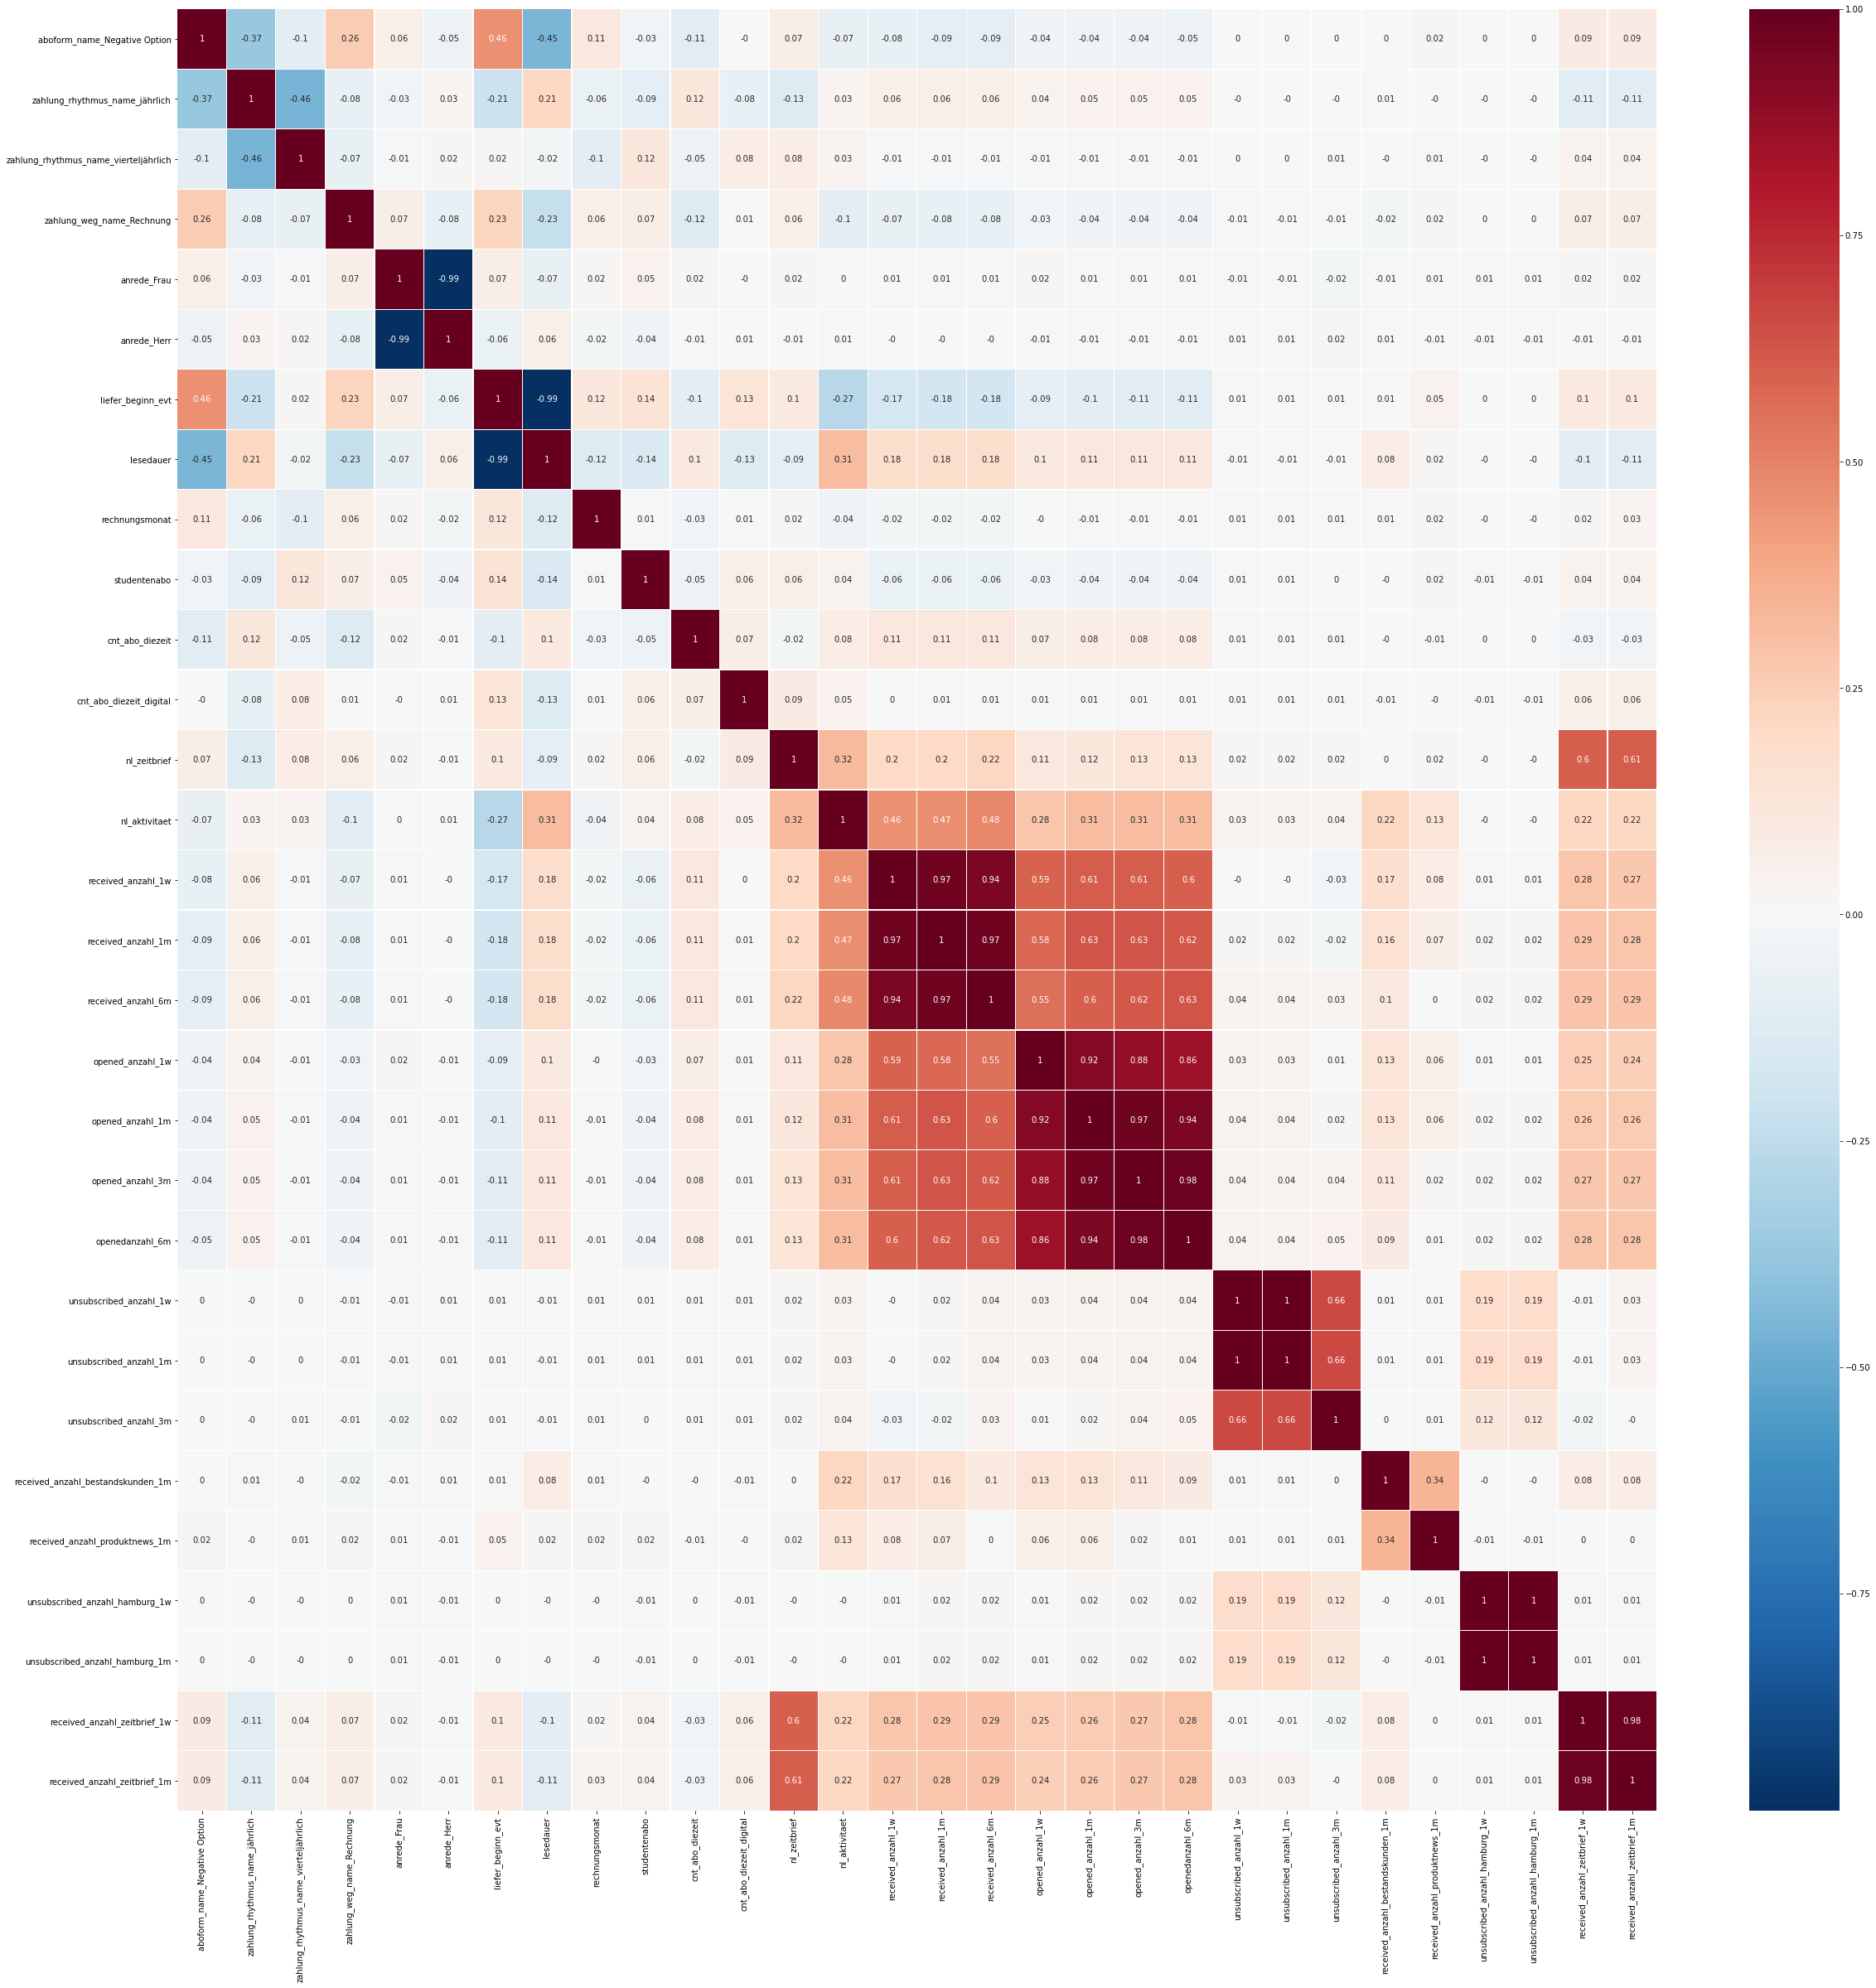

In [44]:
correlogram_combined_features_1 = X_comb[X_comb.columns.intersection(important_features_combined_scale[0:30])]
plt.figure(figsize=(40,40))
sns.heatmap(data=correlogram_combined_features_1.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

In [53]:
removelist1 = ['clicked_anzahl_1m','openrate_zeitbrief_1m','received_anzahl_zeitbrief_1w','received_anzahl_zeitbrief_1m','unsubscribed_anzahl_hamburg_1w','clicked_anzahl_1w','clicked_anzahl_1w','openrate_bestandskunden_1w','anrede_Herr','cnt_abo','zahlung_rhythmus_name_halbjährlich','lesedauer','received_anzahl_1w','received_anzahl_1m','received_anzahl_3m','opened_anzahl_3m','opened_anzahl_1m','opened_anzahl_1w','clicked_anzahl_3m','unsubscribed_anzahl_1w','unsubscribed_anzahl_3m','received_anzahl_bestandskunden_3m','opened_anzahl_produktnews_3m','email_am_kunden','opened_anzahl_bestandskunden_1m','openrate_bestandskunden_3m','clicked_anzahl_produktnews_3m','land_iso_code_DE']

important_features2 = [i for i in important_features_combined_scale if i not in removelist1]
len(important_features2)

49

<AxesSubplot:>

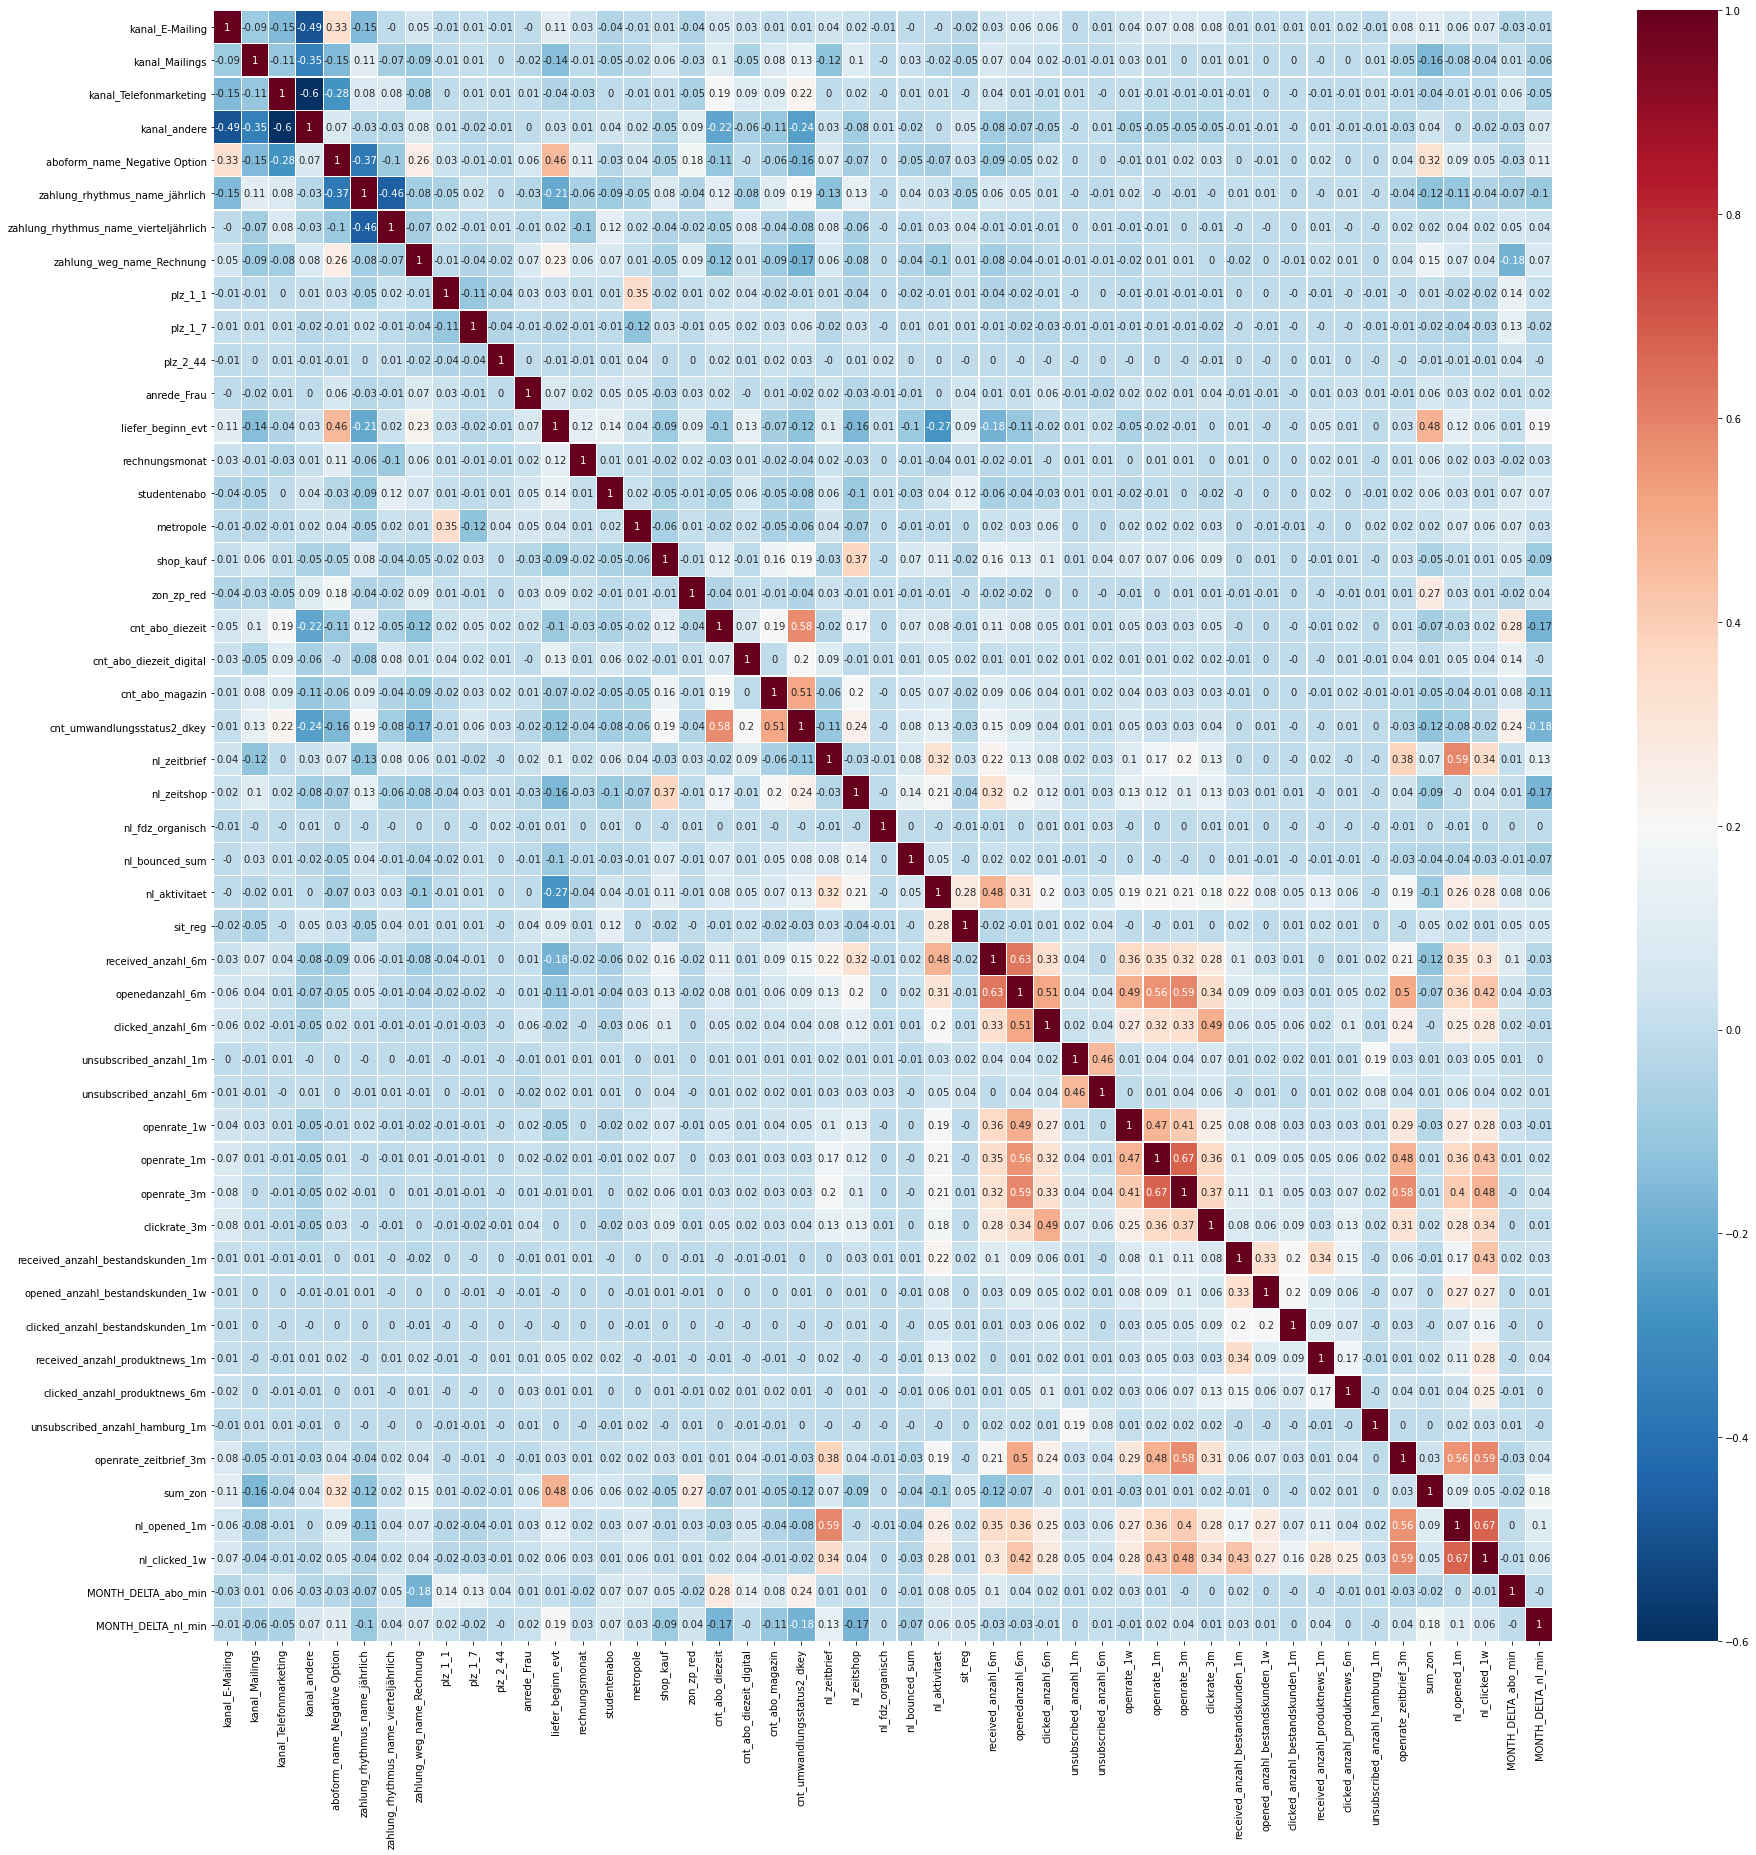

In [54]:
correlogram_combined_features_2 = X_comb[X_comb.columns.intersection(important_features2)]
plt.figure(figsize=(30,30))
sns.heatmap(data=correlogram_combined_features_2.corr().round(2),
           annot=True,
           cmap='RdBu_r',
           linewidths=0.2,
           square=False)

### Final Feature Selection List:

In [55]:
important_features2

['zahlung_weg_name_Rechnung',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_abo_diezeit_digital',
 'cnt_abo_diezeit',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'zahlung_rhythmus_name_vierteljährlich',
 'zahlung_rhythmus_name_jährlich',
 'unsubscribed_anzahl_hamburg_1m',
 'unsubscribed_anzahl_1m',
 'received_anzahl_produktnews_1m',
 'received_anzahl_bestandskunden_1m',
 'nl_fdz_organisch',
 'nl_bounced_sum',
 'kanal_Telefonmarketing',
 'kanal_Mailings',
 'cnt_abo_magazin',
 'clicked_anzahl_produktnews_6m',
 'clicked_anzahl_6m',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min',
 'zon_zp_red',
 'unsubscribed_anzahl_6m',
 'sum_zon',
 'sit_reg',
 'shop_kauf',
 'plz_2_44',
 'plz_1_7',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_3m',
 'openrate_1w',
 'openrate_1m',
 'opened_anzahl_bestandskunden_1w',
 'nl_zeitshop',
 'nl_opened_1m',
 'nl_clicked_1w',
 'metropole',
 'kanal_andere',
 'kanal

['zahlung_weg_name_Rechnung',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_abo_diezeit_digital',
 'cnt_abo_diezeit',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'zahlung_rhythmus_name_vierteljährlich',
 'zahlung_rhythmus_name_jährlich',
 'unsubscribed_anzahl_hamburg_1m',
 'unsubscribed_anzahl_1m',
 'received_anzahl_produktnews_1m',
 'received_anzahl_bestandskunden_1m',
 'nl_fdz_organisch',
 'nl_bounced_sum',
 'kanal_Telefonmarketing',
 'kanal_Mailings',
 'cnt_abo_magazin',
 'clicked_anzahl_produktnews_6m',
 'clicked_anzahl_6m',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min',
 'zon_zp_red',
 'unsubscribed_anzahl_6m',
 'sum_zon',
 'sit_reg',
 'shop_kauf',
 'plz_2_44',
 'plz_1_7',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_3m',
 'openrate_1w',
 'openrate_1m',
 'opened_anzahl_bestandskunden_1w',
 'nl_zeitshop',
 'nl_opened_1m',
 'nl_clicked_1w',
 'metropole',
 'kanal_andere',
 'kanal_E-Mailing',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_3m',
 'clicked_anzahl_bestandskunden_1m']

In [56]:
len(important_features2)

49

-> **49 top features**

# Machine Learning for Customer Segementation

In [67]:
def train_predict(modelname, y_train, y_test, predictions_train, predictions_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - 
       - y_train: income training set
       -
       - y_test: income testing set
    '''
    
    results = {}
    
    # model name 
    results['model'] = modelname
    
    # accuracy
    results['acc_train'] = accuracy_score(y_train,predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # F-score
    #results['f_train'] = fbeta_score(y_train,predictions_train,0.5)
    #results['f_test'] = fbeta_score(y_test,predictions_test,0.5) 
    
    # F1-score
    results['f1_train'] = f1_score(y_train,predictions_train)
    results['f1_test'] = f1_score(y_test,predictions_test) 
    
    # Recall
    results['recall_train'] = recall_score(y_train,predictions_train)
    results['recall_test'] = recall_score(y_test,predictions_test) 
    
    # Precision
    results['precision_train'] = precision_score(y_train,predictions_train)
    results['precision_test'] = precision_score(y_test,predictions_test) 
    
    # Return the results
    return results

In [3]:
def pipeline(X,y,balance=None):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])

    numeric_features = list(X.columns[X.dtypes != object])

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,stratify=y)
    
    if balance == 'over':
        # define oversampling strategy
        print('Oversampling')
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if balance == 'under':
        print('Undersampling')
        # define undersample strategy
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
    
    # defining the models
    #models = [
        #LogisticRegression,
        #DecisionTreeClassifier,
        #RandomForestClassifier, 
        #XGBClassifier,
        #AdaBoostClassifier]
    
    
    models={
        'KNN' : KNeighborsClassifier(n_neighbors=5, metric='euclidean',n_jobs=-1),
        'SVC' : LinearSVC(),
        'logreg': LogisticRegression(random_state=random_state,n_jobs=-1), 
        'decisiontree': DecisionTreeClassifier(random_state=random_state,max_depth=10),
        'randomforest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
        #'randomforest':  RandomForestClassifier(n_jobs=-1,n_estimators=200, criterion='entropy',min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=85,bootstrap=True,random_state=random_state),
        'XGBoost' : XGBClassifier(random_state=random_state, n_jobs=-1),
        'adaBoost' : AdaBoostClassifier(random_state=random_state)
        }  
    
    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        #('scaler', MinMaxScaler())
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])

    model_results = pd.DataFrame(columns=['model','acc_train','acc_test','f1_train','f1_test','recall_train','recall_test','precision_train','precision_test'])
    
    # process pipeline for every model
    for model in models.items():
        
        print(model[0])
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               (model[0], model[1])
                               ])

        # fit model
        pipe.fit(X_train, y_train)

        #predict results
        #y_train_pred = cross_val_predict(pipe, X_train, y_train, cv=5, n_jobs=-1)
        y_train_pred = pipe.predict(X_train)
        y_test_pred = pipe.predict(X_test)
        
        results = train_predict(model[0],y_train, y_test, y_train_pred, y_test_pred)
        
        model_results = pd.concat([model_results, pd.DataFrame(results,index=[0])])
                                                
        conf_mat = pd.crosstab(np.ravel(y_test), np.ravel(y_test_pred),
                               colnames=["Predicted"], rownames=["Actual"])
        sns.heatmap(conf_mat, annot=True, cmap="Blues",fmt='d')
        plt.show()
        plt.close()
                                                
        # print results
        #print("\nResults on training data: ")
        #print(classification_report(y_train, y_train_pred))
        #print("\nResults on test data:")
        #print(classification_report(y_test, y_test_pred))
        print("\nConfusion matrix on test")
        print(confusion_matrix(y_test, y_test_pred))
        print("\n")
    return model_results

## Customer Segmentation - Segment: Die Zeit

### Baseline Models - Top51 Features

In [21]:
# new feature dataframe
df_importance = pd.read_csv('data/df_seg_diezeit_clean_engineered_all.csv')

y = df_importance['churn']
df_importance = df_importance.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

df_importance = pd.get_dummies(df_importance, columns = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name','zahlung_weg_name', 'plz_1', 'plz_2', 'land_iso_code', 'anrede','titel'], drop_first = True)

In [22]:
important_features_combined_dropping = ['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_abo_magazin',
 'cnt_abo_diezeit',
 'clickrate_3m',
 'clicked_anzahl_6m',
 'che_reg',
 'aboform_name_Geschenkabo',
 'MONTH_DELTA_nl_min',
 'unsubscribed_anzahl_1m',
 'titel_sonstiger Titel',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'openrate_produktnews_3m',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'nl_bounced_sum',
 'clickrate_1w',
 'clicked_anzahl_hamburg_3m',
 'aboform_name_Prämienabo',
 'zahlung_rhythmus_name_vierteljährlich',
 'unterbrechung',
 'unsubscribed_anzahl_6m',
 'studentenabo',
 'received_anzahl_produktnews_1m',
 'plz_2_68',
 'plz_2_12',
 'plz_2_10',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_1m',
 'opened_anzahl_bestandskunden_6m',
 'nl_unsubscribed_6m',
 'nl_unsubscribed_1w',
 'nl_opened_1m',
 'nl_fdz_organisch',
 'metropole',
 'kanal_andere',
 'kanal_Eigenwerbung',
 'kanal_B2B',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_produktnews_3m',
 'clicked_anzahl_produktnews_1m',
 'clicked_anzahl_bestandskunden_3m',
 'clicked_anzahl_1w',
 'anrede_Frau',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

In [23]:
df_importance = df_importance[important_features_combined_dropping]

In [24]:
df_importance.shape

(101203, 53)

In [25]:
X = df_importance

Undersampling
KNN


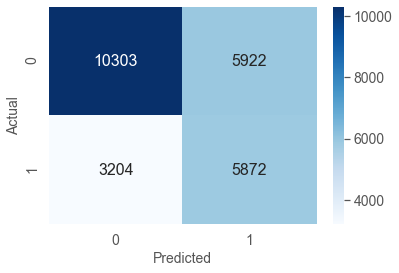


Confusion matrix on test
[[10303  5922]
 [ 3204  5872]]


SVC


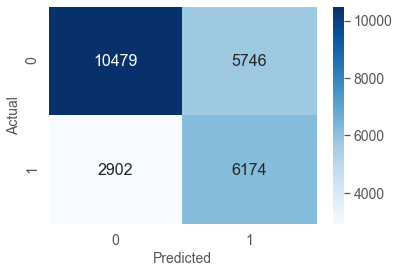


Confusion matrix on test
[[10479  5746]
 [ 2902  6174]]


logreg


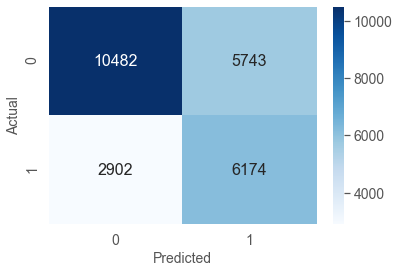


Confusion matrix on test
[[10482  5743]
 [ 2902  6174]]


decisiontree


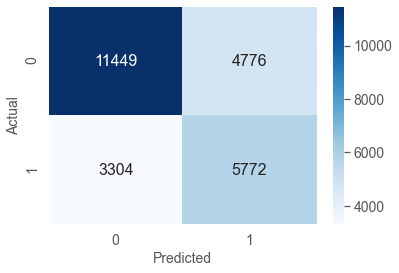


Confusion matrix on test
[[11449  4776]
 [ 3304  5772]]


randomforest


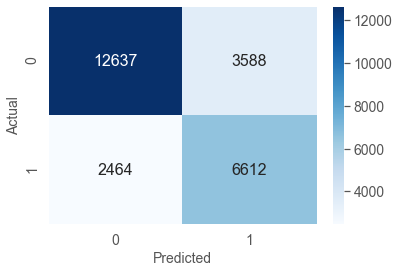


Confusion matrix on test
[[12637  3588]
 [ 2464  6612]]


XGBoost


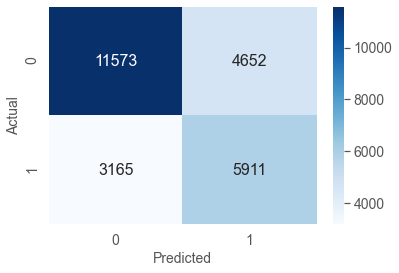


Confusion matrix on test
[[11573  4652]
 [ 3165  5911]]


adaBoost


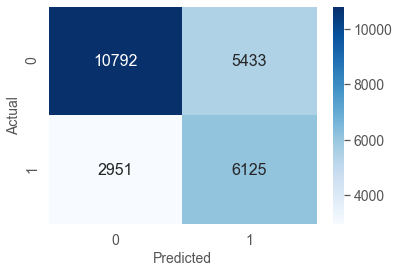


Confusion matrix on test
[[10792  5433]
 [ 2951  6125]]




In [9]:
feature_selection_top100 = pipeline(X,y,balance='under')

In [10]:
feature_selection_top100.round(3)

model  acc_train  acc_test  f1_train  f1_test  recall_train  \
0           KNN      0.768     0.639     0.769    0.563         0.774   
0           SVC      0.662     0.658     0.667    0.588         0.678   
0        logreg      0.662     0.658     0.667    0.588         0.678   
0  decisiontree      0.708     0.681     0.699    0.588         0.680   
0  randomforest      0.999     0.761     0.999    0.686         0.999   
0       XGBoost      0.683     0.691     0.672    0.602         0.649   
0      adaBoost      0.667     0.669     0.668    0.594         0.670   

   recall_test  precision_train  precision_test  
0        0.647            0.764           0.498  
0        0.680            0.656           0.518  
0        0.680            0.657           0.518  
0        0.636            0.720           0.547  
0        0.729            0.999           0.648  
0        0.651            0.697           0.560  
0        0.675            0.666           0.530

### Optimization - RandomForest - Recall

In [26]:
def pipeline_optimization(X,y,balance=None):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])

    numeric_features = list(X.columns[X.dtypes != object])

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,stratify=y)
    
    if balance == 'over':
        # define oversampling strategy
        print('Oversampling')
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if balance == 'under':
        print('Undersampling')
        # define undersample strategy
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
        
    # Hyperparameter grid
    param_randomforest = {
    'randomforest__criterion': ['entropy','gini'], #np.linspace(10, 500,50).astype(int),
    'randomforest__n_estimators': [100, 200, 300, 400, 500, 1000], #np.linspace(10, 500,50).astype(int),
    'randomforest__max_depth': [None] + list(np.arange(5, 100, 5).astype(int)),
    'randomforest__max_features': ['auto', 'sqrt', None],
    'randomforest__bootstrap': [True, False],
    'randomforest__min_samples_leaf': [1, 2, 3],
    'randomforest__min_samples_split': [2, 3, 4],
    }
    
    models={
        #'KNN' : KNeighborsClassifier(n_neighbors=5, metric='euclidean',n_jobs=-1),
        #'SVC' : LinearSVC(),
        #'logreg': LogisticRegression(random_state=random_state,n_jobs=-1), 
        #'decisiontree': DecisionTreeClassifier(random_state=random_state,max_depth=10),
        'randomforest': RandomForestClassifier(random_state=random_state, n_jobs=-1)
        #'XGBoost' : XGBClassifier(random_state=random_state, n_jobs=-1),
        #'adaBoost' : AdaBoostClassifier(random_state=random_state)
        }  
    
    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        #('scaler', MinMaxScaler())
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])

    model_results = pd.DataFrame(columns=['model','acc_train','acc_test','f1_train','f1_test','recall_train','recall_test','precision_train','precision_test'])
    
    # process pipeline for every model
    for model in models.items():
        
        print(model[0])
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               (model[0], model[1])
                               ])

        grid_randomforest = RandomizedSearchCV(pipe, param_randomforest, cv=3, scoring='recall',
                           verbose=5, n_jobs=-1, n_iter = 100)
        # fit model
        grid_randomforest.fit(X_train, y_train)
        #pipe.fit(X_train, y_train)
        
        # Show best parameters
        print('Best score:\n{:.2f}'.format(grid_randomforest.best_score_))
        print("Best parameters:\n{}".format(grid_randomforest.best_params_))
        
        # Save best model as best_model
        best_model = grid_randomforest.best_estimator_
        
        #pipe_best = Pipeline(steps=[('preprocessor', preprocessor), 
        #                       (model[0], best_model)
        #                       ])
        
        # fit best pipe
        #pipe_best.fit(X_train, y_train)
        #predict results
        #y_train_pred = cross_val_predict(grid_randomforest,X_train,y_train,cv=5)
        y_train_pred = grid_randomforest.predict(X_train)
        #y_train_pred = cross_val_predict(pipe_best, X_train, y_train, cv=5)

        y_test_pred = grid_randomforest.predict(X_test)
        
        results = train_predict(model[0],y_train, y_test, y_train_pred, y_test_pred)
        
        model_results = pd.concat([model_results, pd.DataFrame(results,index=[0])])
        # print results
        #print("\nResults on training data: ")
        #print(classification_report(y_train, y_train_pred))
        #print("\nResults on test data:")
        #print(classification_report(y_test, y_test_pred))
        print("\nConfusion matrix on test")
        print(confusion_matrix(y_test, y_test_pred))
        print("\n")
    return model_results

In [28]:
rf_optimization = pipeline_optimization(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 49.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 87.2min finished


Best score:
0.71
Best parameters:
{'randomforest__n_estimators': 300, 'randomforest__min_samples_split': 3, 'randomforest__min_samples_leaf': 2, 'randomforest__max_features': 'sqrt', 'randomforest__max_depth': 50, 'randomforest__criterion': 'entropy', 'randomforest__bootstrap': True}

Confusion matrix on test
[[12587  3638]
 [ 2402  6674]]




In [29]:
rf_optimization

model  acc_train  acc_test  f1_train   f1_test  recall_train  \
0  randomforest   0.968837  0.761274  0.968805  0.688467      0.967791   

   recall_test  precision_train  precision_test  
0     0.735346         0.969821        0.647207

## Customer Segmentation - Segment: Zeit digital

### Baseline Models - Top51 Features

In [59]:
# new feature dataframe
df_importance = pd.read_csv('data/df_seg_zeitdigital_clean_engineered_all.csv')

y = df_importance['churn']
df_importance = df_importance.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

df_importance = pd.get_dummies(df_importance, columns = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name','zahlung_weg_name', 'plz_1', 'plz_2', 'land_iso_code', 'anrede','titel'], drop_first = True)

In [60]:
important_features_combined_dropping = ['zahlung_weg_name_Rechnung',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_abo_diezeit_digital',
 'cnt_abo_diezeit',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'zahlung_rhythmus_name_vierteljährlich',
 'zahlung_rhythmus_name_jährlich',
 'unsubscribed_anzahl_hamburg_1m',
 'unsubscribed_anzahl_1m',
 'received_anzahl_produktnews_1m',
 'received_anzahl_bestandskunden_1m',
 'nl_fdz_organisch',
 'nl_bounced_sum',
 'kanal_Telefonmarketing',
 'kanal_Mailings',
 'cnt_abo_magazin',
 'clicked_anzahl_produktnews_6m',
 'clicked_anzahl_6m',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min',
 'zon_zp_red',
 'unsubscribed_anzahl_6m',
 'sum_zon',
 'sit_reg',
 'shop_kauf',
 'plz_2_44',
 'plz_1_7',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_3m',
 'openrate_1w',
 'openrate_1m',
 'opened_anzahl_bestandskunden_1w',
 'nl_zeitshop',
 'nl_opened_1m',
 'nl_clicked_1w',
 'metropole',
 'kanal_andere',
 'kanal_E-Mailing',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_3m',
 'clicked_anzahl_bestandskunden_1m']

In [61]:
df_importance = df_importance[important_features_combined_dropping]

In [62]:
df_importance.shape

(77081, 49)

In [63]:
X = df_importance

Undersampling
KNN


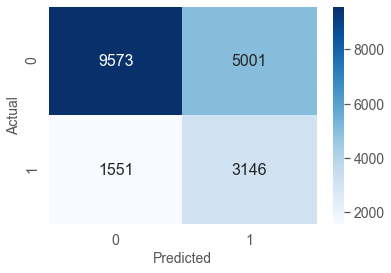


Confusion matrix on test
[[9573 5001]
 [1551 3146]]


SVC


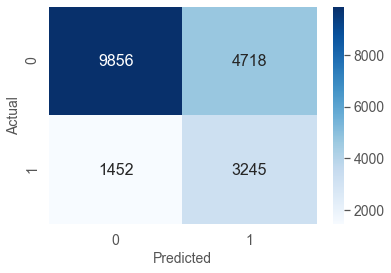


Confusion matrix on test
[[9856 4718]
 [1452 3245]]


logreg


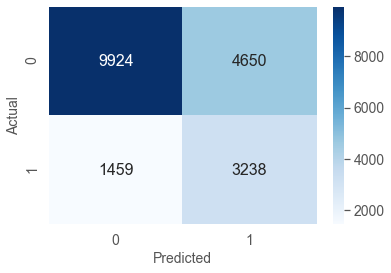


Confusion matrix on test
[[9924 4650]
 [1459 3238]]


decisiontree


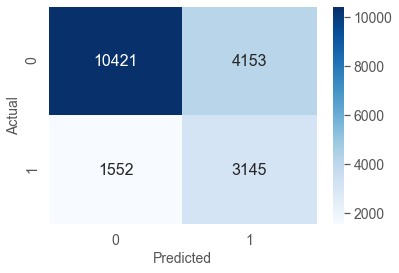


Confusion matrix on test
[[10421  4153]
 [ 1552  3145]]


randomforest


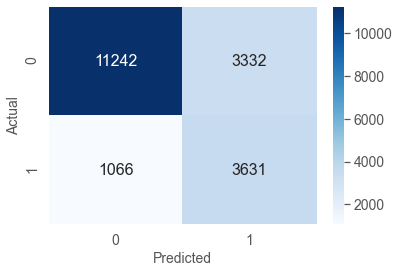


Confusion matrix on test
[[11242  3332]
 [ 1066  3631]]


XGBoost


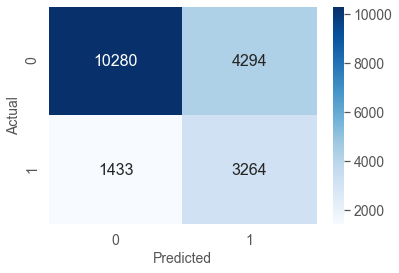


Confusion matrix on test
[[10280  4294]
 [ 1433  3264]]


adaBoost


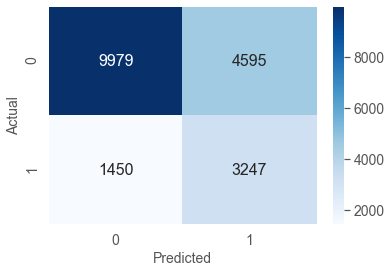


Confusion matrix on test
[[9979 4595]
 [1450 3247]]




In [36]:
feature_selection_top100 = pipeline(X,y,balance='under')

In [38]:
feature_selection_top100.round(3)

model  acc_train  acc_test  f1_train  f1_test  recall_train  \
0           KNN      0.774     0.660     0.777    0.490         0.789   
0           SVC      0.693     0.680     0.697    0.513         0.707   
0        logreg      0.695     0.683     0.698    0.515         0.706   
0  decisiontree      0.756     0.704     0.750    0.524         0.732   
0  randomforest      1.000     0.772     1.000    0.623         1.000   
0       XGBoost      0.713     0.703     0.714    0.533         0.714   
0      adaBoost      0.699     0.686     0.701    0.518         0.707   

   recall_test  precision_train  precision_test  
0        0.670            0.766           0.386  
0        0.691            0.688           0.408  
0        0.689            0.690           0.410  
0        0.670            0.769           0.431  
0        0.773            1.000           0.521  
0        0.695            0.713           0.432  
0        0.691            0.695           0.414

### Optimization - RandomForest - Recall

In [72]:
def pipeline_optimization(X,y,balance=None):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])

    numeric_features = list(X.columns[X.dtypes != object])

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,stratify=y)
    
    if balance == 'over':
        # define oversampling strategy
        print('Oversampling')
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if balance == 'under':
        print('Undersampling')
        # define undersample strategy
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
        
    # Hyperparameter grid
    param_randomforest = {
    'randomforest__criterion': ['entropy','gini'], #np.linspace(10, 500,50).astype(int),
    'randomforest__n_estimators': [100, 200, 300, 400, 500, 1000], #np.linspace(10, 500,50).astype(int),
    'randomforest__max_depth': [None] + list(np.arange(5, 100, 5).astype(int)),
    'randomforest__max_features': ['auto', 'sqrt', None],
    'randomforest__bootstrap': [True, False],
    'randomforest__min_samples_leaf': [1, 2, 3],
    'randomforest__min_samples_split': [2, 3, 4],
    }
    
    models={
        #'KNN' : KNeighborsClassifier(n_neighbors=5, metric='euclidean',n_jobs=-1),
        #'SVC' : LinearSVC(),
        #'logreg': LogisticRegression(random_state=random_state,n_jobs=-1), 
        #'decisiontree': DecisionTreeClassifier(random_state=random_state,max_depth=10),
        'randomforest': RandomForestClassifier(random_state=random_state, n_jobs=-1)
        #'XGBoost' : XGBClassifier(random_state=random_state, n_jobs=-1),
        #'adaBoost' : AdaBoostClassifier(random_state=random_state)
        }  
    
    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        #('scaler', MinMaxScaler())
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])

    model_results = pd.DataFrame(columns=['model','acc_train','acc_test','f1_train','f1_test','recall_train','recall_test','precision_train','precision_test'])
    
    # process pipeline for every model
    for model in models.items():
        
        print(model[0])
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               (model[0], model[1])
                               ])

        grid_randomforest = RandomizedSearchCV(pipe, param_randomforest, cv=3, scoring='precision',
                           verbose=5, n_jobs=-1, n_iter = 100)
        # fit model
        grid_randomforest.fit(X_train, y_train)
        #pipe.fit(X_train, y_train)
        
        # Show best parameters
        print('Best score:\n{:.2f}'.format(grid_randomforest.best_score_))
        print("Best parameters:\n{}".format(grid_randomforest.best_params_))
        
        # Save best model as best_model
        best_model = grid_randomforest.best_estimator_
        
        #pipe_best = Pipeline(steps=[('preprocessor', preprocessor), 
        #                       (model[0], best_model)
        #                       ])
        
        # fit best pipe
        #pipe_best.fit(X_train, y_train)
        #predict results
        #y_train_pred = cross_val_predict(grid_randomforest,X_train,y_train,cv=5)
        y_train_pred = grid_randomforest.predict(X_train)
        #y_train_pred = cross_val_predict(pipe_best, X_train, y_train, cv=5)

        y_test_pred = grid_randomforest.predict(X_test)
        
        results = train_predict(model[0],y_train, y_test, y_train_pred, y_test_pred)
        
        model_results = pd.concat([model_results, pd.DataFrame(results,index=[0])])
        # print results
        #print("\nResults on training data: ")
        #print(classification_report(y_train, y_train_pred))
        #print("\nResults on test data:")
        #print(classification_report(y_test, y_test_pred))
        print("\nConfusion matrix on test")
        print(confusion_matrix(y_test, y_test_pred))
        print("\n")
    return model_results

In [69]:
rf_optimization = pipeline_optimization(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.8min finished


Best score:
0.76
Best parameters:
{'randomforest__n_estimators': 500, 'randomforest__min_samples_split': 2, 'randomforest__min_samples_leaf': 2, 'randomforest__max_features': 'sqrt', 'randomforest__max_depth': 50, 'randomforest__criterion': 'entropy', 'randomforest__bootstrap': True}

Confusion matrix on test
[[11060  3514]
 [ 1050  3647]]




In [70]:
rf_optimization

model  acc_train  acc_test  f1_train   f1_test  recall_train  \
0  randomforest   0.986587  0.763167  0.986628  0.615112      0.989639   

   recall_test  precision_train  precision_test  
0     0.776453         0.983635        0.509286

### Optimization - RandomForest - Precision

In [73]:
rf_optimization_precision = pipeline_optimization(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 31.0min finished


Best score:
0.76
Best parameters:
{'randomforest__n_estimators': 300, 'randomforest__min_samples_split': 2, 'randomforest__min_samples_leaf': 1, 'randomforest__max_features': 'auto', 'randomforest__max_depth': 70, 'randomforest__criterion': 'gini', 'randomforest__bootstrap': False}

Confusion matrix on test
[[11332  3242]
 [ 1103  3594]]




In [75]:
rf_optimization_precision

model  acc_train  acc_test  f1_train   f1_test  recall_train  \
0  randomforest   0.999965  0.774532  0.999965  0.623255      0.999929   

   recall_test  precision_train  precision_test  
0     0.765169              1.0        0.525746

# Conclusion

For the first customer segmentation group (**Die Zeit**) the best results (optimized for recall) of Random Forest are:

- Accuracy:0.761

- Recall: 0.735

- Precision: 0.647

The Recall is a bit lower thank for the prediction of the whole dataset. The Precision is slightly higher. 


For the second customer segmentation group (**Zeit digital**) the best results (optimized for recall) of Random Forest are: 
    
- Accuracy: 0.763

- Recall: 0.776

- Precision: 0.509

The Recall is comparable to the prediciton of the whole dataset, wheareas the Precision is lower.